# Notebook information
This notebook is arranged in order of dataset type and then experiment i.e all operations on a particular dataset; from loading, pre-processing, model training and finally evaluation are done together before moving on to the next dataset.   
   
All functions and code including those for the dataset downloads, pre-processing, adjusted model architectures, new loss function, training and evaluation processes are also included in this notebook (3rd and 4th code cell). The attention mechanism implementations used in this notebook are the PyTorch implementation by `changzy00` on [github](https://github.com/changzy00/pytorch-attention.git).
   
Code cells labeled 

### How to run...   
> **Important**: Please not that this code has to be ran on [Kaggle](https://www.kaggle.com/) as the directory structure within this code has been adapted for it. When you initially upload the notebook to kaggle, and you run the first cell about the breast dataset, it may state that the directory is not found or something in that nature.... Simply navigate to the `Add Input` section, search `breast-ultrasound-images-dataset`, confirm that the dataset used in any of the notebooks is the same as the one [here.](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data) then click on the "+" symbol if it is. Finally, restart your session and the error would be cleared when next you run the cell.

#### *For Homologus Dataset Models*   
- Run the cells from the top, including the pip install line. This will install all necessary libraries not ordinarily installed on Kaggle that are necessary for this project.

#### *For Balanced Dataset models*
- Please note that some cells have been marked with `** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **`. These cells must be ran again if the datasets they operate on have been deleted.
- After that, simply move to the ***Training & Evaluating DeepLabsV3+ (On Balanced Dataset - equal amount of breast, lungs, and lesion)*** section and run all code that follow.

### Dataset Notes
**Breast Cancer Ultrasound Dataset**
- Dataset can be found [here.](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data) ***File size = 266.19 MB***
- Contains: benign, malignant cancer images and masks, as well as normal breast ultrasound images and their corresponding masks (basically blank images).   
- ***DOI: 10.1016/j.dib.2019.104863***   
- ***ISSN: 23523409***

**Lung Segmentation Dataset**
- The dataset can be found [here](https://github.com/IlliaOvcharenko/lung-segmentation/tree/master) or directly through this [link.](https://drive.google.com/file/d/1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ/view?usp=sharing) ***File size = 4.19GB***

**Skin Lesion Segmentation Dataset (ISIC 2017)**
- All ISIC datasets can be found [here](https://challenge.isic-archive.com/data/#2017).
- Training image files can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip) ***File size = 5.8GB***. This dataset consists of 2,000 images.
- Training binary masks can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip) ***File size = 9MB***. This dataset consists of 2,000 masks.
- Validation images can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip) ***File size = 878MB***. This dataset consists of 150 images
- Validation binary masks can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part2_GroundTruth.zip) ***File size = 559KB***. This dataset consists of 150 masks
- Test images can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip) ***File size = 5.4GB***. This dataset consists of 600 images
- Test binary masks can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip) ***File size = 18MB***. This dataset consists of 600 masks
- ***ArXivID: 1710.05006***

# Library downloads.

In [1]:
!pip install gdown && pip install tifffile && git clone https://github.com/changzy00/pytorch-attention.git && pip install segmentation-models-pytorch

Cloning into 'pytorch-attention'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 739 (delta 46), reused 36 (delta 11), pack-reused 645 (from 1)
Receiving objects: 100% (739/739), 3.51 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (339/339), done.
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 20.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=985b0ad46d6e207bc920d6ca891aec70d9307044f6

# Importing Important Libraries

In [2]:
# File System Handling
import os
import gc
import json
import gdown
import shutil
import tarfile
import zipfile

# Data Processing
import cv2
import tifffile
import requests
import numpy as np
import pandas as pd
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Model Training, evaluation processes...
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast

# Handling OutOfMemoryError
import multiprocessing
multiprocessing.set_start_method("spawn", force = True)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

#########################################
import torch.multiprocessing as mp
mp.set_sharing_strategy("file_system")
######################################### Re-run and change num workers back to >1 for multi-processing.

# Advanced experiments (With different attentions).. Using os because of Shell, and Python environment awareness issue
os.chdir("pytorch-attention")
from attention_mechanisms.cbam import CBAM
from attention_mechanisms.se_module import SELayer

# Handling Warnings
import warnings
warnings.filterwarnings("ignore")

print("All libraries succesfully imported, with configurations implemented.")

All libraries succesfully imported, with configurations implemented.


# Auxiliary functions

In [3]:
# All classes and functions in this cell are used later on in this project for the purposes that their
# names suggest. The code below are mostly for data pre-processing, loading and evaluation

class CustomDataset(Dataset):
    def __init__(self, images_paths, labels_paths, train = True, image_size = (512, 512)):
        self.images_paths = images_paths
        self.labels_paths = labels_paths
        self.image_size = image_size
        self.train = train

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])

        # Convert PNG to JPEG
        self.convert_png_to_jpeg()

    def __len__(self):
        return len(self.images_paths) * (2 if self.train else 1)
    
    def __getitem__(self, idx):
        original_idx = idx // 2 if self.train else idx
        is_augmented = self.train and idx % 2 == 1

        image_path = self.images_paths[original_idx]
        label_path = self.labels_paths[original_idx]

        # Read image
        image = Image.open(image_path).convert("RGB")
        
        # Read mask
        if label_path.lower().endswith(".tif") or label_path.lower().endswith(".tiff"):
            mask = tifffile.imread(label_path)
        else:
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 0).astype(np.uint8) * 255  # Ensure binary
        mask = Image.fromarray(mask)

        # Apply augmentations if needed
        if is_augmented:
            image, mask = self.apply_augmentations(image, mask)

        # Apply transformations
        image = self.image_transform(image)
        
        # For mask, use custom transformation to ensure binary output
        mask = TF.resize(mask, self.image_size)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()  # Ensure binary

        return image, mask

    def apply_augmentations(self, image, mask):
        # Random horizontal flipping
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Random vertical flipping
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation
        if torch.rand(1) < 0.5:
            angle = torch.randint(-30, 30, (1,)).item()
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        # Random affine transform
        if torch.rand(1) < 0.5:
            angle = torch.randint(-10, 10, (1,)).item()
            translate = [torch.randint(-20, 20, (1,)).item() / 100.0 for _ in range(2)]
            scale = 1.0 + torch.randint(-10, 10, (1,)).item() / 100.0
            shear = torch.randint(-10, 10, (1,)).item()
            image = TF.affine(image, angle, translate, scale, shear)
            mask = TF.affine(mask, angle, translate, scale, shear)
        
        return image, mask

    def convert_png_to_jpeg(self):
        for i, img_path in enumerate(self.images_paths):
            if img_path.lower().endswith(".png"):
                jpeg_path = os.path.splitext(img_path)[0] + ".jpg"
                if not os.path.exists(jpeg_path):
                    with Image.open(img_path) as img:
                        rgb_img = img.convert("RGB")
                        rgb_img.save(jpeg_path, "JPEG")
                self.images_paths[i] = jpeg_path
    

class DiceBCELoss(nn.Module):
    def __init__(self, weight = 0.5):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight = weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        
        probs = torch.sigmoid(logits)
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        intersection = (probs * targets).sum(1)
        total = probs.sum(1) + targets.sum(1)
        
        dice_loss = 1 - ((2. * intersection + 1e-5) / (total + 1e-5)).mean()
        
        return (1 - self.weight) * bce_loss + self.weight * dice_loss


class DiceBCEIoULoss(nn.Module):
    def __init__(self, bce_weight = 0.3, dice_weight = 0.3, iou_weight = 0.4):
        super(DiceBCEIoULoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.iou_weight = iou_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        
        probs = torch.sigmoid(logits)
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        intersection = (probs * targets).sum(1)
        total = probs.sum(1) + targets.sum(1)
        union = total - intersection
        
        dice_loss = 1 - ((2. * intersection + 1e-5) / (total + 1e-5)).mean()
        iou_loss = 1 - ((intersection + 1e-5) / (union + 1e-5)).mean()
        
        return (self.bce_weight * bce_loss + self.dice_weight * dice_loss + self.iou_weight * iou_loss)

    
def image_denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    img_array = tensor.permute(1, 2, 0).numpy()
    return img_array


def pred_nd_plot(test_loader, model, device, image_denormalize, pred_threshold = 0.5, num_images = 10):
    """
    For plotting image, its true mask, predicted mask, predicted mask on image overlap, and metrics.
    """
    model.eval()  # Set the model to evaluation mode
    it = iter(test_loader)
    
    for i in range(num_images):
        try:
            image, mask = next(it)
        except StopIteration:
            print("Reached the end of the test loader.")
            break
        
        plt.figure(figsize = (15, 5))
        
        # Display the original image
        plt.subplot(1, 4, 1)
        plt.title("Image")
        plt.imshow(image_denormalize(image[0]))
        plt.axis('off')
        
        # Display the true mask
        plt.subplot(1, 4, 2)
        plt.title("True Mask")
        plt.imshow(mask[0][0], cmap = "gray")
        plt.axis('off')
        
        with torch.no_grad():
            # Transfer data to GPU asynchronously
            pred_image = image.to(device, non_blocking = True)
            mask = mask.to(device, non_blocking = True)
            
            output = model(pred_image)
            output = torch.sigmoid(output)
            
            # Calculate metrics
            iou, dice, accuracy = ModelTrainer.calculate_iou_dice_accuracy(output, mask, pred_threshold)
            
            # Apply threshold
            output = (output > pred_threshold).float()
        
        # Display the predicted mask
        plt.subplot(1, 4, 3)
        plt.title(f"Predicted Mask - Threshold ({pred_threshold})\nIoU: {iou:.4f}, Dice: {dice:.4f}, Acc: {accuracy:.4f}")
        plt.imshow(np.array(output.cpu())[0][0], cmap = "gray")
        plt.axis('off')
        
        # Display mask over image
        plt.subplot(1, 4, 4)
        plt.title("Image-Mask Overlay")
        plt.imshow(image_denormalize(image[0]), alpha = 0.5)
        plt.imshow(np.array(output.cpu())[0][0], cmap = "jet", alpha = 0.7)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        
def pred_plot_compare(test_loader, model_1, model_2, device, image_denormalize, pred_threshold = 0.5, num_images = 10, orientation = "box"):
    """
    For plotting image, its true mask, predicted mask (by first model), and predicted mask (by second model).
    Also displays IoU, Dice score, and accuracy for each model.
    
    if "orientation" is set to 'box', images will be (2x2) with figuresize of (5, 5)
    if "orientation" is set to 'line', images will be (1x4) with figuresize of (20, 5)
    """
    model_1.eval()
    model_2.eval()
    it = iter(test_loader)
    
    if orientation == "box":
        fontsize = 8
        figsize = (5, 5)
        subplot_arrangement = (2, 2)
    elif orientation == "line":
        fontsize = 13
        figsize = (20, 5)
        subplot_arrangement = (1, 4)
    else:
        raise Exception("Set 'orientation' = line or box.")
    
    for i in range(num_images):
        try:
            image, mask = next(it)
        except StopIteration:
            print("Reached the end of the test loader.")
            break
        
        plt.figure(figsize = figsize)
        
        # Display the original image
        plt.subplot(subplot_arrangement[0], subplot_arrangement[1], 1)
        plt.title("Image", fontsize = fontsize)
        plt.imshow(image_denormalize(image[0]))
        plt.axis("off")
        
        # Display the true mask
        plt.subplot(subplot_arrangement[0], subplot_arrangement[1], 2)
        plt.title("True Mask", fontsize = fontsize)
        plt.imshow(mask[0][0], cmap = "gray")
        plt.axis('off')
        
        with torch.no_grad():
            # Transfer data to GPU asynchronously
            pred_image = image.to(device, non_blocking = True)
            mask = mask.to(device, non_blocking = True)
            
            # Predict with model_1
            output_1 = model_1(pred_image)
            output_1 = torch.sigmoid(output_1)
            
            # Predict with model_2
            output_2 = model_2(pred_image)
            output_2 = torch.sigmoid(output_2)
            
            # Calculate metrics for model_1
            iou_1, dice_1, accuracy_1 = ModelTrainer.calculate_iou_dice_accuracy(output_1, mask, pred_threshold)
            
            # Calculate metrics for model_2
            iou_2, dice_2, accuracy_2 = ModelTrainer.calculate_iou_dice_accuracy(output_2, mask, pred_threshold)
            
            # Apply threshold
            output_1 = (output_1 > pred_threshold).float()
            output_2 = (output_2 > pred_threshold).float()
        
        # Display the predicted mask from model_1
        plt.subplot(subplot_arrangement[0], subplot_arrangement[1], 3)
        plt.title(f"Model 1 Pred - Threshold ({pred_threshold})\nIoU: {iou_1:.4f}, Dice: {dice_1:.4f}, Acc: {accuracy_1:.4f}", fontsize = fontsize)
        plt.imshow(np.array(output_1.cpu())[0][0], cmap = "gray")
        plt.axis('off')
        
        # Display the predicted mask from model_2
        plt.subplot(subplot_arrangement[0], subplot_arrangement[1], 4)
        plt.title(f"Model 2 Pred - Threshold ({pred_threshold})\nIoU: {iou_2:.4f}, Dice: {dice_2:.4f}, Acc: {accuracy_2:.4f}", fontsize = fontsize)
        plt.imshow(np.array(output_2.cpu())[0][0], cmap = "gray")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        print("Next Set......")
            

class ModelTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, validation_loader, device, 
                 checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint", type_ = "base", 
                 bin_threshold = 0.5, num_epochs = 50, accumulation_steps = 4):
        """
        INPUTS:
            [model]: Instance of the model to be trained.
            [criterion]: Loss/Cost function for training... could be customized as well.
            [optimizer]: Optimization function e.g Adam with learning rate specified.
            [train_loader]: Function for training data loading
            [validation_loader]: Function for validation data loading
            [device]: CPU or cuda ... used to determine where to send data during training
            [checkpoint_dir]: Base directory path for saving best model and latest checkpoints... **default** = /kaggle/working/ModelTrainingCheckpoint
            [type_]: Type of model for experiment tracking... e.g model trained with CBAM will be passed as "cbam". **default** = base
            [bin_threshold]: Threshold value for logit conversion to binary class **default** = 0.5
            [num_epochs]: Number of training epochs... **default** = 50
            [accumulation_steps]: max accumulation steps for gradient accumulation **default** = 4
        
        OUTPUTS:
            [model]: Trained model / Model at last complete epoch.
            [epochs]: Number of epochs completed.
            [train_ious]: IoU on training dataset.
            [train_dices]: Dice score on training set
            [train_accuracies]: Global accuracy on training set
            [train_losses]: Loss on training set
            [val_ious]: IoU on validation set
            [val_dices]: Dice score on validation set
            [val_accuracies]: Global accuracy on validation set
            [val_losses]: Loss on validation set
        """
        
        # Training related
        self.model = model
        self.type_ = type_
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.bin_threshold = bin_threshold
        self.checkpoint_dir = checkpoint_dir
        self.validation_loader = validation_loader
        self.accumulation_steps = accumulation_steps
        
        # Checkpointing related
        self.checkpoint_path = os.path.join(checkpoint_dir, f"best_{type_}_model.pth")
        self.latest_checkpoint_path = os.path.join(checkpoint_dir, f"latest_{type_}_checkpoint.pth")
        self.metrics_path = os.path.join(checkpoint_dir, f"{type_}_metrics.json")
        
        # Initialization of key values.
        self.best_val_iou = float("-inf")
        self.best_val_loss = float("inf")
        self.best_val_dice = float("inf")
        self.start_epoch = 0
        
        # Collecting for visualization.
        self.epochs = []
        self.train_ious, self.train_dices, self.train_accuracies, self.train_losses = [], [], [], []
        self.val_ious, self.val_dices, self.val_accuracies, self.val_losses = [], [], [], []
        
        self.scaler = GradScaler()
        
        self._create_checkpoint_dir()
        self._load_checkpoint()
        self._load_metrics()

    def _create_checkpoint_dir(self):
        os.makedirs(self.checkpoint_dir, exist_ok = True)

    def _load_checkpoint(self):
        if os.path.exists(self.latest_checkpoint_path):
            checkpoint = torch.load(self.latest_checkpoint_path, map_location = self.device) # Incase of CPU/GPU
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            self.start_epoch = checkpoint["epoch"] + 1
            self.best_val_iou = checkpoint["best_val_iou"]
            self.best_val_loss = checkpoint["best_val_loss"]
            print(f"Resuming training from epoch {self.start_epoch}")
        else:
            print("Starting training from scratch")

    def _load_metrics(self):
        if os.path.exists(self.metrics_path):
            with open(self.metrics_path, "r") as f:
                metrics = json.load(f)
            self.epochs = metrics["epochs"]
            self.train_ious = metrics["train_ious"]
            self.train_dices = metrics["train_dices"]
            self.train_accuracies = metrics["train_accuracies"]
            self.train_losses = metrics["train_losses"]
            self.val_ious = metrics["val_ious"]
            self.val_dices = metrics["val_dices"]
            self.val_accuracies = metrics["val_accuracies"]
            self.val_losses = metrics["val_losses"]
            print("Loaded existing metrics.")
        else:
            print("No existing metrics found, starting with empty lists.")

    def _save_metrics(self):
        metrics = {
            'epochs': self.epochs,
            'train_ious': self.train_ious,
            'train_dices': self.train_dices,
            'train_accuracies': self.train_accuracies,
            'train_losses': self.train_losses,
            'val_ious': self.val_ious,
            'val_dices': self.val_dices,
            'val_accuracies': self.val_accuracies,
            'val_losses': self.val_losses
        }
        with open(self.metrics_path, "w") as f:
            json.dump(metrics, f)

    @staticmethod
    def calculate_iou_dice_accuracy(outputs, targets, threshold):
        # Ensure outputs and targets are the same shape
        assert outputs.shape == targets.shape, f"Shape mismatch: outputs {outputs.shape}, targets {targets.shape}"

        # Binarize the outputs
        outputs = (outputs > threshold).float()
        targets = targets.float()

        # Flatten the tensors
        outputs = outputs.view(outputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)

        intersection = (outputs * targets).sum(1)
        union = outputs.sum(1) + targets.sum(1) - intersection

        iou = (intersection + 1e-6) / (union + 1e-6)
        dice = (2 * intersection + 1e-6) / (outputs.sum(1) + targets.sum(1) + 1e-6)
        accuracy = (outputs == targets).float().mean(1)

        return iou.mean(), dice.mean(), accuracy.mean()

    def train(self):
        print(f"\nTraining on: {self.device}, version {torch.version.cuda}")
        print(f"'{self.type_}' training Started... LET's GOOOOOOO !!!!!")
        
        for epoch in range(self.start_epoch, self.num_epochs):
            self._train_epoch(epoch)
            self._validate_epoch(epoch)
            self._save_checkpoint(epoch)
            self._save_metrics()
            
            print(f"Epoch {epoch+1}/{self.num_epochs} ====== "
                  f"Training : (Loss: {self.train_losses[-1]:.4f} - IoU: {self.train_ious[-1]:.4f} - Dice: {self.train_dices[-1]:.4f} - Accuracy: {self.train_accuracies[-1]:.4f}) *=* "
                  f"Validation : (Loss: {self.val_losses[-1]:.4f} - IoU: {self.val_ious[-1]:.4f} - Dice: {self.val_dices[-1]:.4f} - Accuracy: {self.val_accuracies[-1]:.4f})")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            torch.cuda.synchronize()

        return {
            "model": self.model,
            "epochs": self.epochs,
            "train_ious": self.train_ious,
            "train_dices": self.train_dices,
            "train_accuracies": self.train_accuracies,
            "train_losses": self.train_losses,
            "val_ious": self.val_ious,
            "val_dices": self.val_dices,
            "val_accuracies": self.val_accuracies,
            "val_losses": self.val_losses
        }

    def _train_epoch(self, epoch):
        self.model.train()
        running_loss = running_iou = running_dice = running_accuracy = 0.0
        self.epochs.append(epoch + 1)
        accumulated_steps = 0

        for i, (images, masks) in enumerate(self.train_loader):
            images = images.to(self.device, non_blocking = True)
            masks = masks.to(self.device, non_blocking = True)

            self.optimizer.zero_grad()
            with autocast():
                outputs = self.model(images)
                loss = self.criterion(outputs, masks.float())

            self.scaler.scale(loss).backward()

            accumulated_steps += 1
            if accumulated_steps % self.accumulation_steps == 0 or i == len(self.train_loader) - 1:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

            iou, dice, accuracy = self.calculate_iou_dice_accuracy(outputs, masks, self.bin_threshold)

            running_loss += loss.item() * images.size(0)
            running_iou += iou.item() * images.size(0)
            running_dice += dice.item() * images.size(0)
            running_accuracy += accuracy.item() * images.size(0)

        self.train_losses.append(running_loss / len(self.train_loader.dataset))
        self.train_ious.append(running_iou / len(self.train_loader.dataset))
        self.train_dices.append(running_dice / len(self.train_loader.dataset))
        self.train_accuracies.append(running_accuracy / len(self.train_loader.dataset))

    def _validate_epoch(self, epoch):
        self.model.eval()
        val_loss = val_iou = val_dice = val_accuracy = 0.0

        with torch.no_grad():
            for images, masks in self.validation_loader:
                images = images.to(self.device, non_blocking = True)
                masks = masks.to(self.device, non_blocking = True)
                
                with autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)
                
                iou, dice, accuracy = self.calculate_iou_dice_accuracy(outputs, masks, self.bin_threshold)

                val_loss += loss.item() * images.size(0)
                val_iou += iou.item() * images.size(0)
                val_dice += dice.item() * images.size(0)
                val_accuracy += accuracy.item() * images.size(0)

        self.val_losses.append(val_loss / len(self.validation_loader.dataset))
        self.val_ious.append(val_iou / len(self.validation_loader.dataset))
        self.val_dices.append(val_dice / len(self.validation_loader.dataset))
        self.val_accuracies.append(val_accuracy / len(self.validation_loader.dataset))

    def _save_checkpoint(self, epoch):
        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "best_val_iou": self.best_val_iou,
            "best_val_loss": self.best_val_loss,
        }, self.latest_checkpoint_path)

        if self.val_ious[-1] > self.best_val_iou and self.val_losses[-1] < self.best_val_loss:
            self.best_val_iou = max(self.val_ious[-1], self.best_val_iou)
            self.best_val_loss = min(self.val_losses[-1], self.best_val_loss)
            torch.save(self.model.state_dict(), self.checkpoint_path)
            print(f"New Best Model Saved! - Higher IoU & Lower Loss")
        elif self.val_dices[-1] > self.best_val_dice and self.val_losses[-1] < self.best_val_loss:
            self.best_val_dice = max(self.val_dices[-1], self.best_val_dice)
            self.best_val_loss = min(self.val_losses[-1], self.best_val_loss)
            torch.save(self.model.state_dict(), self.checkpoint_path)
            print(f"New Best Model Saved! - Higher Dice & Lower Loss")
            

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x
        return out
    

# Function to calculate metrics for each model and each dataset.
def evaluate_model(model, dataloader, pred_threshold = 0.8):
    model.eval()
    all_iou, all_dice, all_accuracy = [], [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            iou, dice, accuracy = ModelTrainer.calculate_iou_dice_accuracy(outputs, masks, pred_threshold)
            all_iou.append(iou)
            all_dice.append(dice)
            all_accuracy.append(accuracy)
    return {
        "IoU": torch.mean(torch.tensor(all_iou)).item(),
        "Dice Score": torch.mean(torch.tensor(all_dice)).item(),
        "Accuracy": torch.mean(torch.tensor(all_accuracy)).item()
    }


def pred_plot_compare_all(test_loader, model_1, model_2, model_3, device, image_denormalize, num_images=4, pred_threshold=0.5):
    """
    Outputs:
    - Row 1: Original images
    - Row 2: True masks
    - Row 3: Model 1 (Best Base Model) predictions
    - Row 4: Model 2 (Best CBAM Model) predictions
    - Row 5: Model 3 (Best SEBlock Model) predictions
    """
    # Set models to evaluation mode
    model_1.eval()
    model_2.eval()
    model_3.eval()

    # Prepare the grid for displaying the results
    plt.figure(figsize = (5*num_images, 25))

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_images:
                break

            # Denormalize image for display
            image_denorm = image_denormalize(images[0].cpu())

            # Display original image
            plt.subplot(5, num_images, i + 1)
            plt.imshow(image_denorm)
            plt.axis("off")

            # Display true mask
            plt.subplot(5, num_images, num_images + i + 1)
            plt.imshow(masks[0][0].cpu(), cmap = "gray")
            plt.axis('off')
            
            # Predict with each model
            pred_image = images.to(device)
            for j, model in enumerate([model_1, model_2, model_3], start = 2):
                output = torch.sigmoid(model(pred_image))
                output = (output > pred_threshold).float()

                plt.subplot(5, num_images, j * num_images + i + 1)
                plt.imshow(output[0][0].cpu(), cmap = "gray")
                plt.axis('off')
                
    plt.tight_layout()
    plt.show()

In [4]:
# All classes in this cell are used later on in this project for the purposes that their
# names suggest. The code below are code for various versions of DeepLabsV3 and DeepLabsV3+
# Some of which are used in this project and some of which are not used but left for experimenting purposes.

# BASE DEEP LABS V3 MODEL.
class DeepLabsV3(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabsV3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
    def forward(self, x):
        return self.model(x)["out"]


# DEEP LABS V3 MODEL WITH JUST CBAM ATTENTION AFTER ENCODER
class DeepLabV3WithCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCBAM, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels
        
        # Adding CBAM after backbone
        self.cbam = CBAM(backbone_out_channels)
        
        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # upsampling layer to avoid down scale error during training.
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)
        
    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)
        
        # Apply CBAM to the features
        attention_features = self.cbam(features["out"])
        
        # Using refined features for the rest of the model
        x = self.model.classifier(attention_features)
        
        # Upsample the output to match input size
        x = self.upsample(x)
        
        return x


# DEEP LABS V3 MODEL WITH JUST CBAM AND SELF-ATTENTION (SERIAL) AFTER ENCODER
class DeepLabV3WithSelfCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSelfCBAM, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)

        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels

        # Adding CBAM after backbone
        self.cbam = CBAM(backbone_out_channels)

        # Adding self-attention after CBAM
        self.self_attention = SelfAttention(backbone_out_channels)

        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))

        # Upsampling layer to avoid downscale error during training
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)

    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)

        # Apply CBAM to the features
        attention_features = self.cbam(features["out"])

        # Apply self-attention to the features
        self_attention_features = self.self_attention(attention_features)

        # Using refined features for the rest of the model
        x = self.model.classifier(self_attention_features)

        # Upsample the output to match input size
        x = self.upsample(x)

        return x

    
# DEEP LABS V3 MODEL WITH CBAM AND SELF-ATTENTION (SERIAL) + PARALLEL SELF-ATTENTION AFTER ENCODER
class DeepLabV3PlusWithCBAMSAx2(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithCBAMSAx2, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        
        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels
        
        # Adding CBAM after backbone
        self.cbam = CBAM(backbone_out_channels)
        
        # Adding serial self-attention after CBAM
        self.serial_self_attention = SelfAttention(backbone_out_channels)
        
        # Adding parallel self-attention to backbone output
        self.parallel_self_attention = SelfAttention(backbone_out_channels)
        
        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # Upsampling layer to avoid downscale error during training
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)

    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)
        
        # Apply CBAM to the features
        cbam_features = self.cbam(features["out"])
        
        # Apply serial self-attention to the CBAM features
        serial_attention_features = self.serial_self_attention(cbam_features)
        
        # Apply parallel self-attention to the backbone features
        parallel_attention_features = self.parallel_self_attention(features["out"])
        
        # Combine the serial and parallel attention features
        combined_features = serial_attention_features + parallel_attention_features
        
        # Using combined features for the rest of the model
        x = self.model.classifier(combined_features)
        
        # Upsample the output to match input size
        x = self.upsample(x)
        
        return x
    

# DEEP LABS V3 MODEL WITH JUST SELayer ATTENTION AFTER ENCODER
class DeepLabV3WithSELayer(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSELayer, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        
        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels
        
        # Adding SELayer after backbone
        self.SELayer = SELayer(backbone_out_channels)
        
        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # upsampling layer to avoid down scale error during training.
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)
        
    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)
        
        # Apply SELayer to the features
        attention_features = self.SELayer(features["out"])
        
        # Using refined features for the rest of the model
        x = self.model.classifier(attention_features)
        
        # Upsample the output to match input size
        x = self.upsample(x)
        
        return x
    

# LAYER-WISE ATTENTION
class DeepLabV3WithCBAMLayerWise(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCBAMLayerWise, self).__init__()
        
        # Load the pretrained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        
        # Replace the classifier to match the number of output classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # Apply CBAM to the encoder stages (ResNet backbone)
        self.cbam1 = CBAM(256)  # Adjusted to match the channels after layer1
        self.cbam2 = CBAM(512)  # Adjusted to match the channels after layer2
        self.cbam3 = CBAM(1024)  # Adjusted to match the channels after layer3
        self.cbam4 = CBAM(2048)  # Adjusted to match the channels after layer4

    def forward(self, x):
        input_size = x.size()[2:]  # Store the original input size for upsampling
        
        # Encoder: Apply CBAM after each layer
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        
        x = self.model.backbone.layer1(x)
        x = self.cbam1(x)  # Applying CBAM after layer1
        
        x = self.model.backbone.layer2(x)
        x = self.cbam2(x)  # Applying CBAM after layer2
        
        x = self.model.backbone.layer3(x)
        x = self.cbam3(x)  # Applying CBAM after layer3
        
        x = self.model.backbone.layer4(x)
        x = self.cbam4(x)  # Applying CBAM after layer4
        
        x = self.model.classifier(x)  # This layer outputs num_classes channels
        
        # Upsample to match the input resolution
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x


class DeepLabV3WithSELayerAttention(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSELayerAttention, self).__init__()
        
        # Load the pretrained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        
        # Replace the classifier to match the number of output classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # Apply CBAM to the encoder stages (ResNet backbone)
        self.selayer1 = SELayer(256)  # Adjusted to match the channels after layer1
        self.selayer2 = SELayer(512)  # Adjusted to match the channels after layer2
        self.selayer3 = SELayer(1024)  # Adjusted to match the channels after layer3
        self.selayer4 = SELayer(2048)  # Adjusted to match the channels after layer4

    def forward(self, x):
        input_size = x.size()[2:]  # Store the original input size for upsampling
        
        # Encoder: Apply CBAM after each layer
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        
        x = self.model.backbone.layer1(x)
        x = self.selayer1(x)  # Applying SELayer after layer1
        
        x = self.model.backbone.layer2(x)
        x = self.selayer2(x)  # Applying SELayer after layer2
        
        x = self.model.backbone.layer3(x)
        x = self.selayer3(x)  # Applying SELayer after layer3
        
        x = self.model.backbone.layer4(x)
        x = self.selayer4(x)  # Applying SELayer after layer4
        
        x = self.model.classifier(x)  # This layer outputs num_classes channels
        
        # Upsample to match the input resolution
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x


class DeepLabV3WithCbamSEAlternativeAttention(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCbamSEAlternativeAttention, self).__init__()
        
        # Load the pretrained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        
        # Replace the classifier to match the number of output classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # Apply CBAM and SelfAttention alternately to the encoder stages (ResNet backbone)
        self.attention1 = CBAM(256) # Adjusted to match the channels after layer1
        self.attention2 = SELayer(512) # Adjusted to match the channels after layer2
        self.attention3 = CBAM(1024) # Adjusted to match the channels after layer3
        self.attention4 = SELayer(2048) # Adjusted to match the channels after layer4

    def forward(self, x):
        input_size = x.size()[2:]  # Store the original input size for upsampling
        
        # Encoder: Apply CBAM and SelfAttention alternately after each layer
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        
        x = self.model.backbone.layer1(x)
        x = self.attention1(x)  # Applying CBAM after layer1
        
        x = self.model.backbone.layer2(x)
        x = self.attention2(x)  # Applying SELayer after layer2
        
        x = self.model.backbone.layer3(x)
        x = self.attention3(x)  # Applying CBAM after layer3
        
        x = self.model.backbone.layer4(x)
        x = self.attention4(x)  # Applying SELayer after layer4
        
        x = self.model.classifier(x)  # This layer outputs num_classes channels
        
        # Upsample to match the input resolution
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x


# ====== DeepLabsV3+ FROM HERE ON OUT ====== #
class DeepLabsV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabsV3Plus, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name = "resnet50", encoder_weights = "imagenet", classes=num_classes, activation = None)
        
    def forward(self, x):
        return self.model(x)


class DeepLabV3PlusWithLayerWiseCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithLayerWiseCBAM, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name = "resnet50", encoder_weights = "imagenet", classes = num_classes, activation = None)
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize CBAM modules for each encoder stage with correct channel sizes
        self.cbam1 = CBAM(64)
        self.cbam2 = CBAM(256)
        self.cbam3 = CBAM(512)
        self.cbam4 = CBAM(1024)
        self.cbam5 = CBAM(2048)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply CBAM to specific feature maps
        features[1] = self.cbam1(features[1])
        features[2] = self.cbam2(features[2])
        features[3] = self.cbam3(features[3])
        features[4] = self.cbam4(features[4])
        features[5] = self.cbam5(features[5])
        
        decoder_output = self.decoder(*features)
        x = self.segmentation_head(decoder_output)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x


class DeepLabV3PlusWithLayerWiseSELayer(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithLayerWiseSELayer, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name = "resnet50", encoder_weights = "imagenet", classes=num_classes, activation = None)
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize SELayer modules for each encoder stage with correct channel sizes
        self.selayer1 = SELayer(64)
        self.selayer2 = SELayer(256)
        self.selayer3 = SELayer(512)
        self.selayer4 = SELayer(1024)
        self.selayer5 = SELayer(2048)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply CBAM to specific feature maps
        features[1] = self.selayer1(features[1])
        features[2] = self.selayer2(features[2])
        features[3] = self.selayer3(features[3])
        features[4] = self.selayer4(features[4])
        features[5] = self.selayer5(features[5])
        
        decoder_output = self.decoder(*features)
        x = self.segmentation_head(decoder_output)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x


class DeepLabV3WithCBAMEncDec(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCBAMEncDec, self).__init__()
        
        self.model = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", classes=num_classes, activation=None)
        
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Adjust CBAM modules to match the correct feature map sizes
        self.cbam1 = CBAM(64)
        self.cbam2 = CBAM(256)
        self.cbam3 = CBAM(512)
        self.cbam4 = CBAM(1024)
        self.cbam5 = CBAM(2048)
        
        self.cbam_decoder = CBAM(256)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
               
        # Apply CBAM to the second feature map (64 channels)
        features[1] = self.cbam1(features[1])
        features[2] = self.cbam2(features[2])
        features[3] = self.cbam3(features[3])
        features[4] = self.cbam4(features[4])
        features[5] = self.cbam5(features[5])
        
        decoder_output = self.decoder(*features)
        decoder_output = self.cbam_decoder(decoder_output)
        
        x = self.segmentation_head(decoder_output)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners=False)
        
        return x


class DeepLabV3PlusWithLayerWiseSELayerEncDec(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithLayerWiseSELayerEncDec, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name = "resnet50", encoder_weights = "imagenet", classes=num_classes, activation=None)
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize SELayer modules for each encoder stage with correct channel sizes
        self.selayer1 = SELayer(64)
        self.selayer2 = SELayer(256)
        self.selayer3 = SELayer(512)
        self.selayer4 = SELayer(1024)
        self.selayer5 = SELayer(2048)
        
        # Add SELayer for the decoder
        self.selayer_decoder = SELayer(256)  # Assuming the decoder output has 256 channels

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply SE to specific feature maps in the encoder
        features[1] = self.selayer1(features[1])
        features[2] = self.selayer2(features[2])
        features[3] = self.selayer3(features[3])
        features[4] = self.selayer4(features[4])
        features[5] = self.selayer5(features[5])
        
        # Decode
        decoder_output = self.decoder(*features)
        
        # Apply SE to the decoder output
        decoder_output = self.selayer_decoder(decoder_output)
        
        # Segmentation head
        x = self.segmentation_head(decoder_output)
        
        # Upsample to match input size
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x
    
    
# RESNET 101 variants
class DeepLabV3Plus101WithLayerWiseCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus101WithLayerWiseCBAM, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name = "resnet101", encoder_weights = "imagenet", classes = num_classes, activation = None)
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize CBAM modules for each encoder stage with correct channel sizes
        self.cbam1 = CBAM(64)
        self.cbam2 = CBAM(256)
        self.cbam3 = CBAM(512)
        self.cbam4 = CBAM(1024)
        self.cbam5 = CBAM(2048)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply CBAM to specific feature maps
        features[1] = self.cbam1(features[1])
        features[2] = self.cbam2(features[2])
        features[3] = self.cbam3(features[3])
        features[4] = self.cbam4(features[4])
        features[5] = self.cbam5(features[5])
        
        decoder_output = self.decoder(*features)
        x = self.segmentation_head(decoder_output)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x


class DeepLabV3Plus101WithLayerWiseSELayer(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus101WithLayerWiseSELayer, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name = "resnet101", encoder_weights = "imagenet", classes=num_classes, activation = None)
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize SELayer modules for each encoder stage with correct channel sizes
        self.selayer1 = SELayer(64)
        self.selayer2 = SELayer(256)
        self.selayer3 = SELayer(512)
        self.selayer4 = SELayer(1024)
        self.selayer5 = SELayer(2048)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply CBAM to specific feature maps
        features[1] = self.selayer1(features[1])
        features[2] = self.selayer2(features[2])
        features[3] = self.selayer3(features[3])
        features[4] = self.selayer4(features[4])
        features[5] = self.selayer5(features[5])
        
        decoder_output = self.decoder(*features)
        x = self.segmentation_head(decoder_output)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        
        return x

In [5]:
# ** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **

# ** Breast Ultrasound Images Images**
BREAST_ULTRASOUND_DIR = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
BREAST_ULTRASOUND_WORKING = "/kaggle/working/breast-ultrasound"
BREAST_ULTRASOUND_IMAGES = os.path.join(BREAST_ULTRASOUND_WORKING, "images")
BREAST_ULTRASOUND_MASKS = os.path.join(BREAST_ULTRASOUND_WORKING, "masks")


# **Lungs Images**
LUNG_BASE_DIR = "/kaggle/working/lungs/"
LUNG_MASKS_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "masks")
LUNG_IMAGES_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "images")
LUNG_IMAGES = "https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ"


# **Skin Lesion Images**
SKIN_LESION_BASE_DIR = "/kaggle/working/skin_lesion"

SKIN_LESION_TRAIN_IMAGES = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
SKIN_LESION_TRAIN_BINARY_MASKS = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"

SKIN_LESION_VALIDATION_IMAGES = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip"
SKIN_LESION_VALIDATION_BINARY_MASKS = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part1_GroundTruth.zip"

SKIN_LESION_TEST_IMAGES = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip"
SKIN_LESION_TEST_BINARY_MASKS = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip"

# Deep Labs V3+ (On Homologous Dataset - breast cancer, lungs, and lesion separately)

## Breast Ultrasound Images Dataset

In [6]:
# # ** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **

# # CODE CELL TYPE 1 & 2
# breast_uls_image_paths = []
# breast_uls_mask_paths = []

# for sub_dir in os.scandir(BREAST_ULTRASOUND_DIR):
#     for file in os.scandir(sub_dir):
#         if "mask" in file.path:
#             breast_uls_mask_paths.append(file.path)
#         else:
#             breast_uls_image_paths.append(file.path)

# breast_uls_image_paths = sorted(breast_uls_image_paths)
# breast_uls_mask_paths = sorted(breast_uls_mask_paths)

# # Moving images to non-read only destination.
# os.makedirs(BREAST_ULTRASOUND_IMAGES, exist_ok = True)
# new_breast_uls_image_paths = [] # read-and-write destination pathways
# for image in breast_uls_image_paths:
#     shutil.copy(image, os.path.join(BREAST_ULTRASOUND_IMAGES, image.split("/")[-1].split(".")[0]+".jpg"))
#     new_breast_uls_image_paths.append(os.path.join(BREAST_ULTRASOUND_IMAGES, image.split("/")[-1].split(".")[0]+".jpg"))
    

# print(f" There are {len(breast_uls_image_paths)} imgaes, and {len(breast_uls_mask_paths)} masks")
# # At this point, I discovered some images have two or more masks. I have decided
# # to place all multi-masks on top of each other for every given image.

# plt.subplots(1,5, figsize = (10,10))
# plt.subplot(1,5,1)
# plt.title("Image")
# image = Image.open(new_breast_uls_image_paths[2])
# plt.imshow(image)
# plt.axis(False);

# plt.subplot(1,5,2)
# plt.title("Mask 1")
# mask_1 = Image.open(breast_uls_mask_paths[3])
# plt.imshow(mask_1)
# plt.axis(False);

# plt.subplot(1,5,3)
# plt.title("Mask 2")
# mask_2 = Image.open(breast_uls_mask_paths[2])
# plt.imshow(mask_2)
# plt.axis(False);

# plt.subplot(1,5,4)
# plt.title("Combined mask")
# combined = np.maximum(np.array(mask_1).astype(np.uint8), np.array(mask_2).astype(np.uint8)) 
# plt.imshow(combined, cmap = "gray")
# plt.axis(False);

# plt.subplot(1,5,5)
# plt.title("Image-mask overlay")
# combined = np.maximum(np.array(mask_1).astype(np.uint8), np.array(mask_2).astype(np.uint8)) 
# plt.imshow(image, alpha = 0.8)
# plt.imshow(combined, cmap = "gray", alpha = 0.5)
# plt.axis(False);

In [7]:
# # ** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **


# # DO NOT RE-RUN UNLESS DATASET NOT ALREADY SORTED.
# # Creating base dir for adjusted breast masks.
# os.makedirs(BREAST_ULTRASOUND_MASKS, exist_ok = True)
# print("Created adjusted breast masks dir")
# breast_uls_mask_adjusted_paths = [] # Contains combined and single masks

# found = 0
# # Not the best code I've written before, but it gets the work done... = )
# try:
#     for index, mask in enumerate(breast_uls_mask_paths, start = 1):
#         # Checking if the next image in sorted order is the second mask for the same image.
#         # uncomment the next line to see output.
#         # print("Current index:",index, "Current image number:",mask.split("(")[1].split(".")[0].split("_")[0][:-1], "Next Image",breast_uls_mask_paths[index].split("(")[1].split(".")[0].split("_")[0][:-1])            
#         first_mask_id = mask.split("(")[1].split(".")[0].split("_")[0][:-1]
#         next_mask_id = breast_uls_mask_paths[index].split("(")[1].split(".")[0].split("_")[0][:-1]
#         third_mask_id = breast_uls_mask_paths[index + 1].split("(")[1].split(".")[0].split("_")[0][:-1]
#         if  first_mask_id == next_mask_id: # meaning it has at least 2 masks
#             found += 1
#             mask_1 = Image.open(mask)
#             mask_2 = Image.open(breast_uls_mask_paths[index])
            
#             mask_1 = np.array(mask_1).astype(np.uint8)
#             mask_2 = np.array(mask_2).astype(np.uint8)
            
#             # Some second masks have 4 dimesnsions so I'm extracting the maximum values across 3rd dimensions 4 channels.
#             if len(mask_2.shape) == 3:
#                 mask_2 = mask_2.max(axis = 2)
#             combined = np.maximum(mask_1, mask_2) 
#             combinede_mask_img = Image.fromarray(combined)
#             combinede_mask_img.save(os.path.join(BREAST_ULTRASOUND_MASKS, breast_uls_mask_paths[index].split("/")[5]+" ("+str(first_mask_id)+") combined.jpg"))
#             breast_uls_mask_adjusted_paths.append(os.path.join(BREAST_ULTRASOUND_MASKS, breast_uls_mask_paths[index].split("/")[5]+" ("+str(first_mask_id)+") combined.jpg"))
        
#         elif first_mask_id == third_mask_id and first_mask_id == next_mask_id:
#             mask_1 = Image.open(mask)
#             mask_2 = Image.open(breast_uls_mask_paths[index])
#             mask_3 = Image.open(breast_uls_mask_paths[index + 1])

#             mask_1 = np.array(mask_1).astype(np.uint8)
#             mask_2 = np.array(mask_2).astype(np.uint8)
#             mask_3 = np.array(mask_3).astype(np.uint8)
            
#             # Some second masks have 4 dimesnsions so I'm extracting the maximum values across 3rd dimensions 4 channels.
#             if len(mask_2.shape) == 3:
#                 mask_2 = mask_2.max(axis = 2)
#             combined = np.maximum(mask_1, mask_2, mask_3)
#             combinede_mask_img = Image.fromarray(combined) 
#             combinede_mask_img.save(os.path.join(BREAST_ULTRASOUND_MASKS, breast_uls_mask_paths[index].split("/")[5]+" ("+str(first_mask_id)+") combined.jpg"))
#             breast_uls_mask_adjusted_paths.append(os.path.join(BREAST_ULTRASOUND_MASKS, breast_uls_mask_paths[index].split("/")[5]+" ("+str(first_mask_id)+") combined.jpg"))
#         else:
#             if "_mask_1" not in mask:
#                 if "_mask_2" not in mask:
#                     adjusted_mask = Image.open(mask)
#                     adjusted_mask = np.array(adjusted_mask).astype(np.uint8)
#                     if len(adjusted_mask.shape) == 3:
#                         adjusted_mask = adjusted_mask.max(axis = 2)
#                         adjusted_mask = Image.fromarray(adjusted_mask)
#                         adjusted_mask.save(os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))
#                         breast_uls_mask_adjusted_paths.append(os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))
#                     else:
#                         shutil.copy(mask, os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))
#                         breast_uls_mask_adjusted_paths.append(os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))                 
# except IndexError:
#     adjusted_mask = Image.open(mask)
#     adjusted_mask = np.array(adjusted_mask).astype(np.uint8)
#     if len(adjusted_mask.shape) == 3:
#         adjusted_mask = adjusted_mask.max(axis = 2)
#         adjusted_mask = Image.fromarray(adjusted_mask)
#         adjusted_mask.save(os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))
#         breast_uls_mask_adjusted_paths.append(os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))
#     else:
#         shutil.copy(mask, os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))
#         breast_uls_mask_adjusted_paths.append(os.path.join(BREAST_ULTRASOUND_MASKS, mask.split("/")[-1].split(".")[0]+".jpg"))                 

# sorted_breast_uls_image_paths = []
# sorted_breast_uls_mask_paths = []

# for image in new_breast_uls_image_paths:
#     for mask in breast_uls_mask_adjusted_paths:
#         if image.split("/")[-1].split(".")[0] in mask:
#             sorted_breast_uls_image_paths.append(image)
#             sorted_breast_uls_mask_paths.append(mask)

# # Temporarily excluding blank images and masks (normal) to see effects on model performance
# sorted_breast_uls_mask_paths = sorted_breast_uls_mask_paths[:647]
# sorted_breast_uls_image_paths = sorted_breast_uls_image_paths[:647]

# print(f"found and merged {found} multi-masks.")

In [8]:
# i = 270 # i ∈ [0, 647) <--- When 'normal' images are excluded. else upper bound is 780)

# plt.subplots(1,3, figsize = (10,10))
# plt.subplot(1,3,1)
# plt.title("Image")
# image = Image.open(sorted_breast_uls_image_paths[i])
# plt.imshow(image)
# plt.axis(False);

# plt.subplot(1,3,2)
# plt.title("Mask")
# mask = Image.open(sorted_breast_uls_mask_paths[i])
# plt.imshow(mask,cmap = "gray")
# plt.axis(False);

# plt.subplot(1,3,3)
# plt.title("Image-Mask overlay")
# plt.imshow(image, alpha = 0.8)
# plt.imshow(mask, cmap = "gray", alpha = 0.5)
# plt.axis(False);

In [9]:
# # URL to saved checkpoints on my google drive... These checkpoints may be deleted in 2 - 5 years time from
# # 28th September, 2024.

# homologous_breast_uls_checkpoints = {
#     "breast_uls_v3plus_metrics.json":"https://drive.google.com/uc?export=download&id=1Q2ZbtS38rycD914OrggnlR1g8r55sX8N",
#     "best_breast_uls_v3plus_model.pth":"https://drive.google.com/uc?export=download&id=1alrdQ0w0du7AEX979uP8oNmUEl2IrjbB",
#     "latest_breast_uls_v3plus_checkpoint.pth":"https://drive.google.com/uc?export=download&id=1EmgAP-bncyjYwl7GsHkT_v2Skbmm7Wp4",
#     "breast_uls_v3plusCBAMLayerWiseAtt_metrics.json":"https://drive.google.com/uc?export=download&id=1w_62_EovMGsFy7OvdK7mX4llkNPIzuWO",
#     "best_breast_uls_v3plusCBAMLayerWiseAtt_model.pth":"https://drive.google.com/uc?export=download&id=1099Oa67oJb1ngUp2V0uGNYp0mwLthh_W",
#     "latest_breast_uls_v3plusCBAMLayerWiseAtt_checkpoint.pth":"https://drive.google.com/uc?export=download&id=1nMZmlyVg0Qe6lzpPPBul7lf8L_Bc_jN0",
#     "breast_uls_v3plusSeLayerAtt_metrics.json":"https://drive.google.com/uc?export=download&id=1SBEDV4_ULfEGaqmvKpf3e_h5vfxdghnG",
#     "best_breast_uls_v3plusSeLayerAtt_model.pth":"https://drive.google.com/uc?export=download&id=1vgrne70RnPp7c0qov0SDj3SxDUay-J17",
#     "latest_breast_uls_v3plusSeLayerAtt_checkpoint.pth":"https://drive.google.com/uc?export=download&id=1kkdKjQ_xYUffpPj7w6FZkjZjXqG2oYsz",
# }

# # ====> RUN THIS TO DOWNLOAD EXISTING MODEL CHECKPOINTS... <====
# # Creating directory to store saved checkpoints.
# checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint"
# os.makedirs(checkpoint_dir, exist_ok = True)

# # Downloading files.
# for index, (checkpoint_name, checkpoint_url) in enumerate(homologous_breast_uls_checkpoints.items()):
#     print(f"Downloading {checkpoint_name}")
#     file_name = gdown.download(checkpoint_url, os.path.join(checkpoint_dir, checkpoint_name), quiet = True)
# print("\nAll checkpoints downloaded.")

In [10]:
# IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
# BATCH_SIZE = 2
# BIN_THRESHOLD = 0.5 # For probabilities to class.
# TEST_SIZE = 0.15 # Percentage of data to use for testing.
# VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
# NUM_CLASSES = 1 # 1 because it is class against background.
# B_FULL = len(sorted_breast_uls_image_paths) # Breast full data amount

# # Calculating TEST_SIZE, and VAL_SIZE for each data set.
# breast_uls_v_per = int(len(sorted_breast_uls_image_paths) * VAL_SIZE) # Validation size
# breast_uls_t_per = int(len(sorted_breast_uls_image_paths) * TEST_SIZE) # Test size

# # Extracting Training, Test, and Validation data... Extracting first, and last n file paths.
# breast_uls_train_images, breast_uls_train_masks = sorted_breast_uls_image_paths[:B_FULL - (breast_uls_v_per + breast_uls_t_per)], sorted_breast_uls_mask_paths[:B_FULL - (breast_uls_v_per + breast_uls_t_per)] # First "n" file paths
# breast_uls_val_images, breast_uls_val_masks = sorted_breast_uls_image_paths[- (breast_uls_v_per + breast_uls_t_per): - breast_uls_t_per], sorted_breast_uls_mask_paths[- (breast_uls_v_per + breast_uls_t_per): - breast_uls_t_per] # Next "n" starting at first n + 1 and stopping before last.
# breast_uls_test_images, breast_uls_test_masks = sorted_breast_uls_image_paths[- breast_uls_t_per:], sorted_breast_uls_mask_paths[- breast_uls_t_per:] # Last "n"

# print("=" * 82)
# print(f"||-------------||  Training\t||  Validation\t||\tTest\t||     Total\t||")
# print("-" * 82)
# print(f"|| breast_uls  ||\t{len(breast_uls_train_images)}\t||\t{len(breast_uls_val_images)}\t||\t{len(breast_uls_test_images)}\t||\t{B_FULL}\t||")
# print("=" * 82)

In [11]:
# breast_uls_train_dataset = CustomDataset(breast_uls_train_images, breast_uls_train_masks, train = True, image_size = IMAGE_SIZE)
# breast_uls_train_loader = DataLoader(breast_uls_train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading validation data
# breast_uls_validation_dataset = CustomDataset(breast_uls_val_images, breast_uls_val_masks, train = False, image_size = IMAGE_SIZE)
# breast_uls_validation_loader = DataLoader(breast_uls_validation_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading Test data
# breast_uls_test_dataset = CustomDataset(breast_uls_test_images, breast_uls_test_masks, train = False, image_size = IMAGE_SIZE)
# breast_uls_test_loader = DataLoader(breast_uls_test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# print(f"Dataset Summary (Post-Augmentation, and Transformations).\n")
# print("=" * 66)
# print(f"||----------------||   Training\t||  Validation\t||\tTest\t||")
# print("-" * 66)
# print(f"|| Full Dataset   ||\t{len(breast_uls_train_dataset)}\t||\t{len(breast_uls_validation_dataset)}\t||\t{len(breast_uls_test_dataset)}\t||")
# print(f"|| Batch Size\t  ||\t{len(breast_uls_train_dataset)//len(breast_uls_train_loader)}\t||\t{len(breast_uls_validation_dataset)//len(breast_uls_validation_loader)}\t||\t{len(breast_uls_test_dataset)//len(breast_uls_test_loader)}\t||")
# print(f"|| No. of Batches ||\t{len(breast_uls_train_loader)}\t||\t{len(breast_uls_validation_loader)}\t||\t{len(breast_uls_test_loader)}\t||")
# print("=" * 66)

In [12]:
# criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# breast_uls_base_model = DeepLabsV3Plus(NUM_CLASSES).to(device)
# breast_uls_base_optimizer = optim.Adam(breast_uls_base_model.parameters(), lr = 0.001)
# breast_uls_base_model = breast_uls_base_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# breast_uls_base_trainer = ModelTrainer(
#     model = breast_uls_base_model,
#     criterion = criterion,
#     optimizer = breast_uls_base_optimizer,
#     train_loader = breast_uls_train_loader,
#     validation_loader = breast_uls_validation_loader,
#     device = device,
#     num_epochs = 200,
#     type_ = "breast_uls_v3plus"
# )
# # Training models.
# breast_uls_base_contents = breast_uls_base_trainer.train()

In [13]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# breast_uls_cbam_model = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# breast_uls_cbam_optimizer = optim.Adam(breast_uls_cbam_model.parameters(), lr = 0.001)
# breast_uls_cbam_model = breast_uls_cbam_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# breast_uls_cbam_trainer = ModelTrainer(
#     model = breast_uls_cbam_model,
#     criterion = criterion,
#     optimizer = breast_uls_cbam_optimizer,
#     train_loader = breast_uls_train_loader,
#     validation_loader = breast_uls_validation_loader,
#     device = device,
#     num_epochs = 200,
#     type_ = "breast_uls_v3plusCBAMLayerWiseAtt"
# )

# # Training models.
# breast_uls_cmab_contents = breast_uls_cbam_trainer.train()

In [14]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# breast_uls_se_model = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# breast_uls_se_optimizer = optim.Adam(breast_uls_se_model.parameters(), lr = 0.001)
# breast_uls_se_model = breast_uls_se_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# breast_uls_se_trainer = ModelTrainer(
#     model = breast_uls_se_model,
#     criterion = criterion,
#     optimizer = breast_uls_se_optimizer,
#     train_loader = breast_uls_train_loader,
#     validation_loader = breast_uls_validation_loader,
#     device = device,
#     num_epochs = 200,
#     type_ = "breast_uls_v3plusSeLayerAtt"
# )

# # Training models.
# breast_uls_se_contents = breast_uls_se_trainer.train()

In [15]:
# plt.subplots(2, 2, figsize = (20, 10))
# plt.title("GRAPH SHOWING VARIOUS ATTENTION IN ENCODER VAL METRICS - breast_uls DATASET")

# plt.subplot(2, 2, 1)
# plt.title("Various Models IoUs (Breast uls dataset)")
# plt.plot(breast_uls_base_contents["val_ious"], label = "Base Val IoU")
# plt.plot(breast_uls_cmab_contents["val_ious"], label = "Multi-layered CMAB Val IoU")
# plt.plot(breast_uls_se_contents["val_ious"], label = "Multi-layered SElayer att IoU")
# plt.xlabel("Epoch")
# plt.ylabel("IoU")
# plt.legend()


# plt.subplot(2, 2, 2)
# plt.title("Various Models Dice Scores (Breast uls dataset)")
# plt.plot(breast_uls_base_contents["val_dices"], label = "Base Dice")
# plt.plot(breast_uls_cmab_contents["val_dices"], label = "Multi-layered CMAB Val Dice")
# plt.plot(breast_uls_se_contents["val_dices"], label = "Multi-layered SElayer att Dice")
# plt.xlabel("Epoch")
# plt.ylabel("Dice Scores")
# plt.legend()


# plt.subplot(2, 2, 3)
# plt.title("Various Models Global Accuracy (Breast uls dataset)")
# plt.plot(breast_uls_base_contents["val_accuracies"], label = "Base Accuracy")
# plt.plot(breast_uls_cmab_contents["val_accuracies"], label = "Multi-layered CMAB Val Accuracy")
# plt.plot(breast_uls_se_contents["val_accuracies"], label = "Multi-layered SElayer att Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy Scores")
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.title("Various Models Losses (Breast uls dataset)")
# plt.plot(breast_uls_base_contents["val_losses"], label = "Base Val Loss")
# plt.plot(breast_uls_cmab_contents["val_losses"], label = "Multi-layered CMAB Val. loss")
# plt.plot(breast_uls_se_contents["val_losses"], label = "Multi-layered SElayer Val. loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [16]:
# print(f"Model (at final epoch) Performance Metrices on Validation Dataset.\n")
# print("=" * 90)
# print(f"||Metric / Model\t||   Base Model\t|| CBAM Layer Attention ||  SELayer Attention\t||")
# print("=" * 90)
# print(f"|| Max Dice\t\t||\t{max(breast_uls_base_contents['val_dices']):.4f}\t||\t{max(breast_uls_cmab_contents['val_dices']):.4f}\t\t||\t{max(breast_uls_se_contents['val_dices']):.4f}\t\t||")
# print(f"|| Mean Dice\t\t||\t{(sum(breast_uls_base_contents['val_dices']) / len(breast_uls_base_contents['val_dices'])):.4f}\t||\t{(sum(breast_uls_cmab_contents['val_dices']) / len(breast_uls_cmab_contents['val_dices'])):.4f}\t\t||\t{(sum(breast_uls_se_contents['val_dices']) / len(breast_uls_se_contents['val_dices'])):.4f}\t\t||")
# print(f"|| Dice σ (Std.)\t||\t{np.std(np.array(breast_uls_base_contents['val_dices'])):.4f}\t||\t{np.std(np.array(breast_uls_cmab_contents['val_dices'])):.4f}\t\t||\t{np.std(np.array(breast_uls_se_contents['val_dices'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max IoU\t\t||\t{max(breast_uls_base_contents['val_ious']):.4f}\t||\t{max(breast_uls_cmab_contents['val_ious']):.4f}\t\t||\t{max(breast_uls_se_contents['val_ious']):.4f}\t\t||")
# print(f"|| Mean IoU\t\t||\t{(sum(breast_uls_base_contents['val_ious']) / len(breast_uls_base_contents['val_ious'])):.4f}\t||\t{(sum(breast_uls_cmab_contents['val_ious']) / len(breast_uls_cmab_contents['val_ious'])):.4f}\t\t||\t{(sum(breast_uls_se_contents['val_ious']) / len(breast_uls_se_contents['val_ious'])):.4f}\t\t||")
# print(f"|| IoU σ (Std.)\t\t||\t{np.std(np.array(breast_uls_base_contents['val_ious'])):.4f}\t||\t{np.std(np.array(breast_uls_cmab_contents['val_ious'])):.4f}\t\t||\t{np.std(np.array(breast_uls_se_contents['val_ious'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max Accuracy\t\t||\t{max(breast_uls_base_contents['val_accuracies']):.4f}\t||\t{max(breast_uls_cmab_contents['val_accuracies']):.4f}\t\t||\t{max(breast_uls_se_contents['val_accuracies']):.4f}\t\t||")
# print(f"|| Mean Accuracy\t||\t{(sum(breast_uls_base_contents['val_accuracies']) / len(breast_uls_base_contents['val_accuracies'])):.4f}\t||\t{(sum(breast_uls_cmab_contents['val_accuracies']) / len(breast_uls_cmab_contents['val_accuracies'])):.4f}\t\t||\t{(sum(breast_uls_se_contents['val_accuracies']) / len(breast_uls_se_contents['val_accuracies'])):.4f}\t\t||")
# print(f"|| Accuracy σ (Std.)\t||\t{np.std(np.array(breast_uls_base_contents['val_accuracies'])):.4f}\t||\t{np.std(np.array(breast_uls_cmab_contents['val_accuracies'])):.4f}\t\t||\t{np.std(np.array(breast_uls_se_contents['val_accuracies'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Min Loss\t\t||\t{min(breast_uls_base_contents['val_losses']):.4f}\t||\t{min(breast_uls_cmab_contents['val_losses']):.4f}\t\t||\t{min(breast_uls_se_contents['val_losses']):.4f}\t\t||")
# print(f"|| Mean Loss\t\t||\t{(sum(breast_uls_base_contents['val_losses']) / len(breast_uls_base_contents['val_losses'])):.4f}\t||\t{(sum(breast_uls_cmab_contents['val_losses']) / len(breast_uls_cmab_contents['val_losses'])):.4f}\t\t||\t{(sum(breast_uls_se_contents['val_losses']) / len(breast_uls_se_contents['val_losses'])):.4f}\t\t||")
# print(f"|| Loss σ (Std.)\t||\t{np.std(np.array(breast_uls_base_contents['val_losses'])):.4f}\t||\t{np.std(np.array(breast_uls_cmab_contents['val_losses'])):.4f}\t\t||\t{np.std(np.array(breast_uls_se_contents['val_losses'])):.4f}\t\t||")
# print("=" * 90)

In [17]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# breast_uls_base_best = DeepLabsV3Plus(NUM_CLASSES).to(device)
# breast_uls_base_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_breast_uls_v3plus_model.pth"))
# breast_uls_cbam_best = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# breast_uls_cbam_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_breast_uls_v3plusCBAMLayerWiseAtt_model.pth"))
# breast_uls_se_best = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# breast_uls_se_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_breast_uls_v3plusSeLayerAtt_model.pth"))

# # Models
# models = {
#     "base": breast_uls_base_best,
#     "cmab": breast_uls_cbam_best,
#     "se": breast_uls_se_best,
# }

# # Datasets
# datasets = {
#     "breast_uls_val": breast_uls_validation_loader,
#     "breast_uls_test": breast_uls_test_loader,
#     }

# # Evaluate each model on each dataset
# print("Currently making predictions, and evaluating")
# results = {}
# for model_name, model in models.items():
#     model_results = {}
#     for dataset_name, dataloader in datasets.items():
#         model_results[dataset_name] = evaluate_model(model, dataloader)
#     results[model_name] = model_results
# print("Prediction, and evaluation complete...\n")

# # Display results
# data_rows = []
# for model_name, model_results in results.items():
#     for dataset_name, metrics in model_results.items():
#         data_row = [model_name, dataset_name, metrics['IoU'], metrics['Dice Score'], metrics['Accuracy']]
#         data_rows.append(data_row)

# # Create a DataFrame
# df = pd.DataFrame(data_rows, columns = ["Model", "Dataset", "IoU", "Dice Score", "Accuracy"])

# # Pivot the DataFrame to get the desired format
# pivot_df = df.pivot(index = "Dataset", columns = "Model", values = ["IoU", "Dice Score", "Accuracy"])

# # Flatten the multi-level column index
# pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]

# # Print the table
# pivot_df

In [18]:
# # Base Vs CBAM attention
# pred_plot_compare(breast_uls_test_loader, breast_uls_base_best, breast_uls_cbam_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3, orientation = "box")

In [19]:
# # Base Vs SeLayer attention
# pred_plot_compare(breast_uls_test_loader, breast_uls_base_best, breast_uls_se_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [20]:
# # CBAM Vs SeLayer attention
# pred_plot_compare(breast_uls_test_loader, breast_uls_cbam_best, breast_uls_se_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [21]:
# pred_plot_compare_all(breast_uls_test_loader,breast_uls_base_best,breast_uls_cbam_best,breast_uls_se_best,device, image_denormalize)

In [22]:
# # Deleting every breast cancer related checkpoints and data to create space.
# shutil.rmtree("/kaggle/working/breast-ultrasound")
# shutil.rmtree("/kaggle/working/ModelTrainingCheckpoint")

# Lungs Images Dataset

In [23]:
# # ** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **

# # DO NOT RE-RUN UNLESS DATASET NOT ALREADY DOWNLOADED, AND SORTED.

# # Creating base dir for lung images
# os.makedirs(LUNG_BASE_DIR, exist_ok = True)
# print("Created Lungs dir")

# # Downloading dataset.
# print("Downloading images...")
# gdown.download(LUNG_IMAGES, LUNG_BASE_DIR, quiet = True)
# print("Download completed... Unzipping")

# # Finding file.
# zipped_file_name = [file.name for file in os.scandir(LUNG_BASE_DIR)][0]

# # Extracting downloaded dataset
# with tarfile.open(os.path.join(LUNG_BASE_DIR, zipped_file_name), "r:gz") as zip_ref:
#     zip_ref.extractall(LUNG_BASE_DIR)
# print("Image zip file content extracted")
    
# # Deleting zipped file
# os.remove(os.path.join(LUNG_BASE_DIR, zipped_file_name))
# print("Zipped file deleted.")

In [24]:
# # ** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **

# # Sorting Train Image Paths... Extracting first 704 lung images because there are only 704 masks.
# lung_image_paths = sorted([os.path.join(LUNG_IMAGES_DIR, path) for path in os.listdir(LUNG_IMAGES_DIR)])
# lung_mask_paths = sorted([os.path.join(LUNG_MASKS_DIR, path) for path in os.listdir(LUNG_MASKS_DIR)])

# print(f"Lungs:\nThere are {len(lung_image_paths)} images, and {len(lung_mask_paths)} masks.")

# masks = []
# images = []

# for image in os.listdir(LUNG_IMAGES_DIR):
#     for mask in os.listdir(LUNG_MASKS_DIR):
#         if image.split(".")[0] in mask.split(".")[0]:
#             images.append(os.path.join(LUNG_IMAGES_DIR, image))
#             masks.append(os.path.join(LUNG_MASKS_DIR, mask))

# lung_image_paths = sorted(images)
# lung_mask_paths = sorted(masks)

# print(f"Matching Lungs:\nThere are {len(lung_image_paths)} images, and {len(lung_mask_paths)} masks.")

In [25]:
# # Sample of a lung image and label.

# # i ∈ [0, 704)
# i = 703 # Adjust to see different images.

# plt.subplots(1,2, figsize = (10,10))

# plt.subplot(1,2,1)
# plt.title("Lung Image")
# im = Image.open(lung_image_paths[i])
# plt.imshow(im, cmap = "gray")
# plt.axis(False);

# plt.subplot(1,2,2)
# plt.title("Lung Mask")
# im = Image.open(lung_mask_paths[i])
# plt.axis(False)
# plt.imshow(im, cmap = "gray")

# plt.tight_layout();

In [26]:
# # Creating balanced dataset.
# # Defining Standardz.
# IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
# BATCH_SIZE = 2
# BIN_THRESHOLD = 0.5 # For probabilities to class.
# TEST_SIZE = 0.15 # Percentage of data to use for testing.
# VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
# NUM_CLASSES = 1 # 1 because it is class against background.

# LU_FULL = len(lung_image_paths) # Lungs full data amount

# # Calculating TEST_SIZE, and VAL_SIZE for each data set.
# lung_v_per = int(len(lung_image_paths) * VAL_SIZE) # Validation size
# lung_t_per = int(len(lung_image_paths) * TEST_SIZE) # Test size

# # Extracting Training, Test, and Validation data... Extracting first, and last n file paths.
# lung_train_images, lung_train_masks = lung_image_paths[:LU_FULL - (lung_v_per + lung_t_per)], lung_mask_paths[:LU_FULL - (lung_v_per + lung_t_per)] # First "n" file paths
# lung_val_images, lung_val_masks = lung_image_paths[- (lung_v_per + lung_t_per): - lung_t_per], lung_mask_paths[- (lung_v_per + lung_t_per): - lung_t_per] # Next "n" starting at first n + 1 and stopping before last.
# lung_test_images, lung_test_masks = lung_image_paths[- lung_t_per:], lung_mask_paths[- lung_t_per:] # Last "n"

# print("=" * 74)
# print(f"||--------||  Training\t||  Validation\t||\tTest\t||     Total\t||")
# print("-" * 74)
# print(f"|| Lungs  ||\t{len(lung_train_images)}\t||\t{len(lung_val_images)}\t||\t{len(lung_test_images)}\t||\t{LU_FULL}\t||")
# print("=" * 74)

In [27]:
# lung_train_dataset = CustomDataset(lung_train_images, lung_train_masks, train = True, image_size = IMAGE_SIZE)
# lung_train_loader = DataLoader(lung_train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading validation data
# lung_validation_dataset = CustomDataset(lung_val_images, lung_val_masks, train = False, image_size = IMAGE_SIZE)
# lung_validation_loader = DataLoader(lung_validation_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading Test data
# lung_test_dataset = CustomDataset(lung_test_images, lung_test_masks, train = False, image_size = IMAGE_SIZE)
# lung_test_loader = DataLoader(lung_test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# print(f"Dataset Summary (Post-Augmentation, and Transformations).\n")
# print("=" * 66)
# print(f"||----------------||   Training\t||  Validation\t||\tTest\t||")
# print("-" * 66)
# print(f"|| Full Dataset   ||\t{len(lung_train_dataset)}\t||\t{len(lung_validation_dataset)}\t||\t{len(lung_test_dataset)}\t||")
# print(f"|| Batch Size\t  ||\t{len(lung_train_dataset)//len(lung_train_loader)}\t||\t{len(lung_validation_dataset)//len(lung_validation_loader)}\t||\t{len(lung_test_dataset)//len(lung_test_loader)}\t||")
# print(f"|| No. of Batches ||\t{len(lung_train_loader)}\t||\t{len(lung_validation_loader)}\t||\t{len(lung_test_loader)}\t||")
# print("=" * 66)

In [28]:
# # URL to saved checkpoints on my google drive... These checkpoints may be deleted in 2 - 5 years time from
# # 28th September, 2024.

# homologous_lungs_checkpoints = {
#     "lung_v3plus_metrics.json":"https://drive.google.com/uc?export=download&id=1rRgx2p6l_AOu0Zz05fyQrlnUWdBgzzdY",
#     "best_lung_v3plus_model.pth":"https://drive.google.com/uc?export=download&id=1XwzHLBBM_U7JnjmE8ooWFs7W9cgq_yjz",
#     "latest_lung_v3plus_checkpoint.pth":"https://drive.google.com/uc?export=download&id=1_fOKNyzoM9hCI8T5GvxR30ANiYCD0fc3",
#     "lung_v3plusCBAMLayerWiseAtt_metrics.json" : "https://drive.google.com/uc?export=download&id=17rP3tu9FYmKB0WtfDWFEeRS5MOplUg_3",
#     "best_lung_v3plusCBAMLayerWiseAtt_model.pth" : "https://drive.google.com/uc?export=download&id=16JZtneIloS14_ix1XY9NhcqOcOK_VFyq",
#     "latest_lung_v3plusCBAMLayerWiseAtt_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1cdM7Z41RFbukbRQMVVHX7f3GLfZ5Nkzz",
#     "lung_v3plusSeLayerAtt_metrics.json" : "https://drive.google.com/uc?export=download&id=11inw2QLYsOnGcMUQGl-QNWMhihJ056QS",
#     "best_lung_v3plusSeLayerAtt_model.pth" : "https://drive.google.com/uc?export=download&id=1rumgj9ZrYhcavHAtxU-l5zXhreM7LUkX",
#     "latest_lung_v3plusSeLayerAtt_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1KI5g0CBHCzpOb9LM5V_V5aWyDExKvZxo"
# }

# # ====> RUN THIS DO DOWNLOAD EXISTING MODEL CHECKPOINTS... <====
# # Creating directory to store saved checkpoints.
# checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint"
# os.makedirs(checkpoint_dir, exist_ok = True)

# # Downloading files.
# for index, (checkpoint_name, checkpoint_url) in enumerate(homologous_lungs_checkpoints.items()):
#     print(f"Downloading {checkpoint_name}")
#     file_name = gdown.download(checkpoint_url, os.path.join(checkpoint_dir, checkpoint_name), quiet = True)
# print("\nAll checkpoints downloaded.")

In [29]:
# criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lung_base_model = DeepLabsV3Plus(NUM_CLASSES).to(device)
# lung_base_optimizer = optim.Adam(lung_base_model.parameters(), lr = 0.001)
# lung_base_model = lung_base_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# lung_base_trainer = ModelTrainer(
#     model = lung_base_model,
#     criterion = criterion,
#     optimizer = lung_base_optimizer,
#     train_loader = lung_train_loader,
#     validation_loader = lung_validation_loader,
#     device = device,
#     num_epochs = 30,
#     type_ = "lung_v3plus"
# )
# # Training models.
# lung_base_contents = lung_base_trainer.train()

In [30]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lung_cbam_model = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# lung_cbam_optimizer = optim.Adam(lung_cbam_model.parameters(), lr = 0.001)
# lung_cbam_model = lung_cbam_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# lung_cbam_trainer = ModelTrainer(
#     model = lung_cbam_model,
#     criterion = criterion,
#     optimizer = lung_cbam_optimizer,
#     train_loader = lung_train_loader,
#     validation_loader = lung_validation_loader,
#     device = device,
#     num_epochs = 30,
#     type_ = "lung_v3plusCBAMLayerWiseAtt"
# )

# # Training models.
# lung_cmab_contents = lung_cbam_trainer.train()

In [31]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lung_se_model = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# lung_se_optimizer = optim.Adam(lung_se_model.parameters(), lr = 0.001)
# lung_se_model = lung_se_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# lung_se_trainer = ModelTrainer(
#     model = lung_se_model,
#     criterion = criterion,
#     optimizer = lung_se_optimizer,
#     train_loader = lung_train_loader,
#     validation_loader = lung_validation_loader,
#     device = device,
#     num_epochs = 30,
#     type_ = "lung_v3plusSeLayerAtt"
# )

# # Training models.
# lung_se_contents = lung_se_trainer.train()

In [32]:
# plt.subplots(2, 2, figsize = (20, 10))
# plt.title("GRAPH SHOWING VARIOUS ATTENTION IN ENCODER VAL METRICS - LUNG DATASET")

# plt.subplot(2, 2, 1)
# plt.title("Various Models IoUs (lung dataset)")
# plt.plot(lung_base_contents["val_ious"], label = "Base Val IoU")
# plt.plot(lung_cmab_contents["val_ious"], label = "Multi-layered CMAB Val IoU")
# plt.plot(lung_se_contents["val_ious"], label = "Multi-layered SElayer att IoU")
# plt.xlabel("Epoch")
# plt.ylabel("IoU")
# plt.legend()


# plt.subplot(2, 2, 2)
# plt.title("Various Models Dice Scores (lung dataset)")
# plt.plot(lung_base_contents["val_dices"], label = "Base Dice")
# plt.plot(lung_cmab_contents["val_dices"], label = "Multi-layered CMAB Val Dice")
# plt.plot(lung_se_contents["val_dices"], label = "Multi-layered SElayer att Dice")
# plt.xlabel("Epoch")
# plt.ylabel("Dice Scores")
# plt.legend()


# plt.subplot(2, 2, 3)
# plt.title("Various Models Global Accuracy (lung dataset)")
# plt.plot(lung_base_contents["val_accuracies"], label = "Base Accuracy")
# plt.plot(lung_cmab_contents["val_accuracies"], label = "Multi-layered CMAB Val Accuracy")
# plt.plot(lung_se_contents["val_accuracies"], label = "Multi-layered SElayer att Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy Scores")
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.title("Various Models Losses (lung dataset)")
# plt.plot(lung_base_contents["val_losses"], label = "Base Val Loss")
# plt.plot(lung_cmab_contents["val_losses"], label = "Multi-layered CMAB Val. loss")
# plt.plot(lung_se_contents["val_losses"], label = "Multi-layered SElayer Val. loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [33]:
# print(f"Model Performance Metrices on Validation Dataset.\n")
# print("=" * 90)
# print(f"||Metric / Model\t||   Base Model\t|| CBAM Layer Attention ||  SELayer Attention\t||")
# print("=" * 90)
# print(f"|| Max Dice\t\t||\t{max(lung_base_contents['val_dices']):.4f}\t||\t{max(lung_cmab_contents['val_dices']):.4f}\t\t||\t{max(lung_se_contents['val_dices']):.4f}\t\t||")
# print(f"|| Mean Dice\t\t||\t{(sum(lung_base_contents['val_dices']) / len(lung_base_contents['val_dices'])):.4f}\t||\t{(sum(lung_cmab_contents['val_dices']) / len(lung_cmab_contents['val_dices'])):.4f}\t\t||\t{(sum(lung_se_contents['val_dices']) / len(lung_se_contents['val_dices'])):.4f}\t\t||")
# print(f"|| Dice σ (Std.)\t||\t{np.std(np.array(lung_base_contents['val_dices'])):.4f}\t||\t{np.std(np.array(lung_cmab_contents['val_dices'])):.4f}\t\t||\t{np.std(np.array(lung_se_contents['val_dices'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max IoU\t\t||\t{max(lung_base_contents['val_ious']):.4f}\t||\t{max(lung_cmab_contents['val_ious']):.4f}\t\t||\t{max(lung_se_contents['val_ious']):.4f}\t\t||")
# print(f"|| Mean IoU\t\t||\t{(sum(lung_base_contents['val_ious']) / len(lung_base_contents['val_ious'])):.4f}\t||\t{(sum(lung_cmab_contents['val_ious']) / len(lung_cmab_contents['val_ious'])):.4f}\t\t||\t{(sum(lung_se_contents['val_ious']) / len(lung_se_contents['val_ious'])):.4f}\t\t||")
# print(f"|| IoU σ (Std.)\t\t||\t{np.std(np.array(lung_base_contents['val_ious'])):.4f}\t||\t{np.std(np.array(lung_cmab_contents['val_ious'])):.4f}\t\t||\t{np.std(np.array(lung_se_contents['val_ious'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max Accuracy\t\t||\t{max(lung_base_contents['val_accuracies']):.4f}\t||\t{max(lung_cmab_contents['val_accuracies']):.4f}\t\t||\t{max(lung_se_contents['val_accuracies']):.4f}\t\t||")
# print(f"|| Mean Accuracy\t||\t{(sum(lung_base_contents['val_accuracies']) / len(lung_base_contents['val_accuracies'])):.4f}\t||\t{(sum(lung_cmab_contents['val_accuracies']) / len(lung_cmab_contents['val_accuracies'])):.4f}\t\t||\t{(sum(lung_se_contents['val_accuracies']) / len(lung_se_contents['val_accuracies'])):.4f}\t\t||")
# print(f"|| Accuracy σ (Std.)\t||\t{np.std(np.array(lung_base_contents['val_accuracies'])):.4f}\t||\t{np.std(np.array(lung_cmab_contents['val_accuracies'])):.4f}\t\t||\t{np.std(np.array(lung_se_contents['val_accuracies'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Min Loss\t\t||\t{min(lung_base_contents['val_losses']):.4f}\t||\t{min(lung_cmab_contents['val_losses']):.4f}\t\t||\t{min(lung_se_contents['val_losses']):.4f}\t\t||")
# print(f"|| Mean Loss\t\t||\t{(sum(lung_base_contents['val_losses']) / len(lung_base_contents['val_losses'])):.4f}\t||\t{(sum(lung_cmab_contents['val_losses']) / len(lung_cmab_contents['val_losses'])):.4f}\t\t||\t{(sum(lung_se_contents['val_losses']) / len(lung_se_contents['val_losses'])):.4f}\t\t||")
# print(f"|| Loss σ (Std.)\t||\t{np.std(np.array(lung_base_contents['val_losses'])):.4f}\t||\t{np.std(np.array(lung_cmab_contents['val_losses'])):.4f}\t\t||\t{np.std(np.array(lung_se_contents['val_losses'])):.4f}\t\t||")
# print("=" * 90)

In [34]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# lung_base_best = DeepLabsV3Plus(NUM_CLASSES).to(device)
# lung_base_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lung_v3plus_model.pth"))
# lung_cbam_best = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# lung_cbam_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lung_v3plusCBAMLayerWiseAtt_model.pth"))
# lung_se_best = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# lung_se_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lung_v3plusSeLayerAtt_model.pth"))

# # Models
# models = {
#     "base": lung_base_best,
#     "cmab": lung_cbam_best,
#     "se": lung_se_best
# }

# # Datasets
# datasets = {
#     "lung_val": lung_validation_loader,
#     "lung_test": lung_test_loader,
#     }

# # Evaluate each model on each dataset
# print("Currently making predictions, and evaluating")
# results = {}
# for model_name, model in models.items():
#     model_results = {}
#     for dataset_name, dataloader in datasets.items():
#         model_results[dataset_name] = evaluate_model(model, dataloader)
#     results[model_name] = model_results
# print("Prediction, and evaluation complete...\n")

# # Display results
# data_rows = []
# for model_name, model_results in results.items():
#     for dataset_name, metrics in model_results.items():
#         data_row = [model_name, dataset_name, metrics["IoU"], metrics["Dice Score"], metrics["Accuracy"]]
#         data_rows.append(data_row)

# # Create a DataFrame
# df = pd.DataFrame(data_rows, columns = ["Model", "Dataset", "IoU", "Dice Score", "Accuracy"])

# # Pivot the DataFrame to get the desired format
# pivot_df = df.pivot(index = "Dataset", columns = "Model", values = ["IoU", "Dice Score", "Accuracy"])

# # Flatten the multi-level column index
# pivot_df.columns = [" ".join(col).strip() for col in pivot_df.columns.values]

# # Print the table
# pivot_df

In [35]:
# # Base Vs CBAM attention
# pred_plot_compare(lung_test_loader, lung_base_best, lung_cbam_best, device, image_denormalize, pred_threshold = 0.7, num_images = 3)

In [36]:
# # Base Vs SeLayer attention
# pred_plot_compare(lung_test_loader, lung_base_best, lung_se_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [37]:
# # CBAM Vs SeLayer attention
# pred_plot_compare(lung_test_loader, lung_cbam_best, lung_se_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [38]:
# pred_plot_compare_all(lung_test_loader,lung_base_best,lung_cbam_best,lung_se_best,device, image_denormalize)

In [39]:
# # Deleting every lung related checkpoints and data to create space.
# shutil.rmtree("/kaggle/working/lungs")
# shutil.rmtree("/kaggle/working/ModelTrainingCheckpoint")

## Skin lesion Images Dataset

In [40]:
# DO NOT RE-RUN UNLESS DATASET NOT ALREADY DOWNLOADED, AND SORTED.

# Creating base dir for lung images
os.makedirs(SKIN_LESION_BASE_DIR, exist_ok = True)
print("Created Lesion dir")

# ================================= TRAINING IMAGES & MASKS ================================= #
# Downloading TRAINING dataset.
print("Training images downloading...")
response = requests.get(SKIN_LESION_TRAIN_IMAGES, stream = True)

with open(os.path.join(SKIN_LESION_BASE_DIR, "train_images_dataset.zip"), "wb") as file:
    for chunk in response.iter_content(chunk_size = 2000):
        file.write(chunk)
print("Training Images download complete.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "train_images_dataset.zip"), "r") as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
print("Training images zip file content extracted")
    
# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "train_images_dataset.zip"))
print("Training images zipped file deleted.")

# Downloading TRAINING binary masks.
print("Training binary mask downloading...")
response = requests.get(SKIN_LESION_TRAIN_BINARY_MASKS, stream = True)
with open(os.path.join(SKIN_LESION_BASE_DIR, "train_bin_mask.zip"), "wb") as file:
    for chunk in response.iter_content(chunk_size = 250):
        file.write(chunk)
print("Training binary masks download complete.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "train_bin_mask.zip"), "r") as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
print("Training binary masks zip file content extracted")

os.remove(os.path.join(SKIN_LESION_BASE_DIR, "train_bin_mask.zip"))
print("Training binary masks zipped file deleted.")


# ================================ VALIDATION IMAGES & MASKS =============================== #
response = requests.get(SKIN_LESION_VALIDATION_IMAGES, stream = True)

# Downloading VALIDATION dataset
print("\nValidation images downloading...")
with open(os.path.join(SKIN_LESION_BASE_DIR, "validation_images_dataset.zip"), "wb") as file:
    for chunk in response.iter_content(chunk_size = 250):
        file.write(chunk)
print("Validation images download complete.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "validation_images_dataset.zip"), "r") as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
print("Validation images zip file content extracted")

# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "validation_images_dataset.zip"))
print("Validation images zipped file deleted.")

# Downloading VALIDATION binary masks.
print("Validation binary mask downloading...")
response = requests.get(SKIN_LESION_VALIDATION_BINARY_MASKS, stream = True)
with open(os.path.join(SKIN_LESION_BASE_DIR, "validation_bin_mask.zip"), "wb") as file:
    for chunk in response.iter_content(chunk_size = 128):
        file.write(chunk)
print("Validation binary masks download complete.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "validation_bin_mask.zip"), "r") as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
print("Validation binary masks zip file content extracted")

os.remove(os.path.join(SKIN_LESION_BASE_DIR, "validation_bin_mask.zip"))
print("Validation binary masks zipped file deleted.")


# ================================= TEST IMAGES & MASKS ================================= #
response = requests.get(SKIN_LESION_TEST_IMAGES, stream = True)

# Downloading TEST dataset
print("\nTest images downloading...")
with open(os.path.join(SKIN_LESION_BASE_DIR, "test_images_dataset.zip"), "wb") as file:
    for chunk in response.iter_content(chunk_size = 2000):
        file.write(chunk)
print("Test images download complete.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "test_images_dataset.zip"), "r") as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
print("Test images zip file content extracted")

# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "test_images_dataset.zip"))
print("Test images zipped file deleted.")

# Downloading TEST binary masks.
print("Test binary mask downloading...")
response = requests.get(SKIN_LESION_TEST_BINARY_MASKS, stream = True)
with open(os.path.join(SKIN_LESION_BASE_DIR, "test_bin_mask.zip"), "wb") as file:
    for chunk in response.iter_content(chunk_size = 250):
        file.write(chunk)
print("Test binary masks download complete.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "test_bin_mask.zip"), "r") as zip_ref:
    zip_ref.extractall(SKIN_LESION_BASE_DIR)
print("Test binary masks zip file content extracted")

os.remove(os.path.join(SKIN_LESION_BASE_DIR, "test_bin_mask.zip"))
print("Test binary masks zipped file deleted.")

# Moving csv file out to avoid mismatch issues later.
os.rename(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data", "ISIC-2017_Training_Data_metadata.csv"), os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
os.rename(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Validation_Data", "ISIC-2017_Validation_Data_metadata.csv"), os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Validation_Data_metadata.csv"))
os.rename(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Data_metadata.csv"), os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Test_v2_Data_metadata.csv"))
print("CSVs moved to desired location.")

Created Lesion dir
Training images downloading...
Training Images download complete.
Training images zip file content extracted
Training images zipped file deleted.
Training binary mask downloading...
Training binary masks download complete.
Training binary masks zip file content extracted
Training binary masks zipped file deleted.

Validation images downloading...
Validation images download complete.
Validation images zip file content extracted
Validation images zipped file deleted.
Validation binary mask downloading...
Validation binary masks download complete.
Validation binary masks zip file content extracted
Validation binary masks zipped file deleted.

Test images downloading...
Test images download complete.
Test images zip file content extracted
Test images zipped file deleted.
Test binary mask downloading...
Test binary masks download complete.
Test binary masks zip file content extracted
Test binary masks zipped file deleted.
CSVs moved to desired location.


In [41]:
train_csv = pd.read_csv(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
train_csv.head()

,image_id,age_approximate,sex
0,ISIC_0000000,55,female
1,ISIC_0000001,30,female
2,ISIC_0000002,60,female
3,ISIC_0000003,30,male
4,ISIC_0000004,80,male


In [42]:
val_csv = pd.read_csv(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Validation_Data_metadata.csv"))
val_csv.head()

,image_id,age_approximate,sex
0,ISIC_0001769,15,female
1,ISIC_0001852,10,female
2,ISIC_0001871,15,male
3,ISIC_0003462,15,female
4,ISIC_0003539,15,female


In [43]:
test_csv = pd.read_csv(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Test_v2_Data_metadata.csv"))
test_csv.head()

,image_id,age_approximate,sex
0,ISIC_0012086,30,male
1,ISIC_0012092,40,male
2,ISIC_0012095,25,male
3,ISIC_0012134,75,female
4,ISIC_0012136,70,male


In [44]:
# Sorting Train, Validation, and Test Image Paths,
# and deleting superpixel images.

for _ in range(2) : # Running twice to delete superpixel images then None values.
    lesion_training_image_paths = [image.path if not image.path.endswith("png") else os.remove(image.path) for image in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data"))]
    lesion_training_mask_paths = [mask.path for mask in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Part1_GroundTruth"))]

    lesion_validation_image_paths = [image.path if not image.path.endswith("png") else os.remove(image.path) for image in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Validation_Data"))]
    lesion_validation_mask_paths = [mask.path for mask in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Validation_Part1_GroundTruth"))]

    lesion_test_image_paths = [image.path if not image.path.endswith("png") else os.remove(image.path) for image in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Test_v2_Data"))]
    lesion_test_mask_paths = [mask.path for mask in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Test_v2_Part1_GroundTruth"))]


lesion_training_image_paths = sorted(lesion_training_image_paths)
lesion_training_mask_paths = sorted(lesion_training_mask_paths)

lesion_validation_image_paths = sorted(lesion_validation_image_paths)
lesion_validation_mask_paths = sorted(lesion_validation_mask_paths)

lesion_test_image_paths = sorted(lesion_test_image_paths)
lesion_test_mask_paths = sorted(lesion_test_mask_paths)

LU_FULL = sum([len(lesion_training_image_paths), len(lesion_validation_image_paths), len(lesion_test_image_paths)])
print(f"There are {len(lesion_training_image_paths)} training images, and {len(lesion_training_mask_paths)} masks")
print(f"There are {len(lesion_validation_image_paths)} validation images, and {len(lesion_validation_mask_paths)} masks")
print(f"There are {len(lesion_test_image_paths)} testing images, and {len(lesion_test_mask_paths)} masks")

There are 2000 training images, and 2000 masks
There are 150 validation images, and 150 masks
There are 600 testing images, and 600 masks


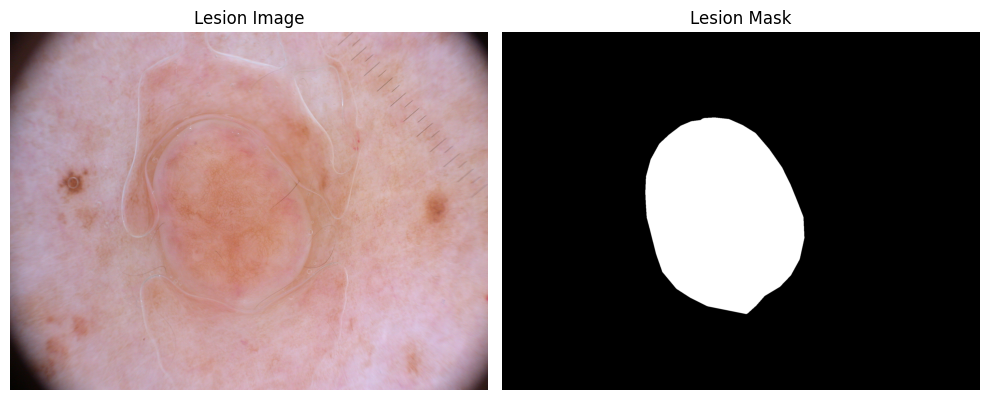

In [45]:
# Sample of a lesion image and label.

# 0 >= i <= 1999
i = 82 # Adjust to see different images.

plt.subplots(1,2, figsize = (10,10))

plt.subplot(1,2,1)
plt.title("Lesion Image")
image = Image.open(lesion_training_image_paths[i])
plt.imshow(image, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lesion Mask")
mask = Image.open(lesion_training_mask_paths[i])
plt.axis(False)
plt.imshow(mask, cmap = "gray")

plt.tight_layout();

In [46]:
IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
BATCH_SIZE = 8
BIN_THRESHOLD = 0.5 # For probabilities to class.
NUM_CLASSES = 1 # 1 because it is class against background.

print("=" * 74)
print(f"||--------||  Training\t||  Validation\t||\tTest\t||     Total\t||")
print("-" * 74)
print(f"|| lesions  ||\t{len(lesion_training_image_paths)}\t||\t{len(lesion_validation_image_paths)}\t||\t{len(lesion_test_image_paths)}\t||\t{LU_FULL}\t||")
print("=" * 74)

||--------||  Training	||  Validation	||	Test	||     Total	||
--------------------------------------------------------------------------
|| lesions  ||	2000	||	150	||	600	||	2750	||


In [47]:
lesion_train_dataset = CustomDataset(lesion_training_image_paths, lesion_training_mask_paths, train = True, image_size = IMAGE_SIZE)
lesion_train_loader = DataLoader(lesion_train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# Loading validation data
lesion_validation_dataset = CustomDataset(lesion_validation_image_paths, lesion_validation_mask_paths, train = False, image_size = IMAGE_SIZE)
lesion_validation_loader = DataLoader(lesion_validation_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# Loading Test data
lesion_test_dataset = CustomDataset(lesion_test_image_paths, lesion_test_mask_paths, train = False, image_size = IMAGE_SIZE)
lesion_test_loader = DataLoader(lesion_test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

print(f"Dataset Summary (Post-Augmentation, and Transformations).\n")
print("=" * 66)
print(f"||----------------||   Training\t||  Validation\t||\tTest\t||")
print("-" * 66)
print(f"|| Full Dataset   ||\t{len(lesion_train_dataset)}\t||\t{len(lesion_validation_dataset)}\t||\t{len(lesion_test_dataset)}\t||")
print(f"|| Batch Size\t  ||\t{len(lesion_train_dataset)//len(lesion_train_loader)}\t||\t{len(lesion_validation_dataset)//len(lesion_validation_loader)}\t||\t{len(lesion_test_dataset)//len(lesion_test_loader)}\t||")
print(f"|| No. of Batches ||\t{len(lesion_train_loader)}\t||\t{len(lesion_validation_loader)}\t||\t{len(lesion_test_loader)}\t||")
print("=" * 66)

Dataset Summary (Post-Augmentation, and Transformations).

||----------------||   Training	||  Validation	||	Test	||
------------------------------------------------------------------
|| Full Dataset   ||	4000	||	150	||	600	||
|| Batch Size	  ||	8	||	8	||	8	||
|| No. of Batches ||	500	||	18	||	75	||


In [48]:
# URL to saved checkpoints on my google drive... These checkpoints may be deleted in 2 - 5 years time from
# 28th September, 2024.

# homologous_lesion_checkpoints = {
#     "lesion_v3plus_metrics.json":"https://drive.google.com/uc?export=download&id=1OHMpVlL0F5cfCHL0rLJv__bHXiP2HJMu",
#     "best_lesion_v3plus_model.pth":"https://drive.google.com/uc?export=download&id=1_nfuLH-AhzVlA3DeIlDfXaBbTVox845Q",
#     "latest_lesion_v3plus_checkpoint.pth":"https://drive.google.com/uc?export=download&id=19Bi9lupvdRai0U6_dhZ30MIAp2zNhzYs",
#     "lesion_v3plusCBAMLayerWiseAtt_metrics.json" : "https://drive.google.com/uc?export=download&id=1Uk_TrKAQIzyt_K22czXGVRNqv-JE78eQ",
#     "best_lesion_v3plusCBAMLayerWiseAtt_model.pth" : "https://drive.google.com/uc?export=download&id=13K9--27Wg7luecuK4JM8mChuFnYix8sh",
#     "latest_lesion_v3plusCBAMLayerWiseAtt_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1hkUMInM62TKaVpbYG_eeCSyh8dlFkOSs",
#     "lesion_v3plusSeLayerAtt_metrics.json" : "https://drive.google.com/uc?export=download&id=1R7WMk7FJdFUrvRKq6TFMmNCpJ9Jkd0es",
#     "best_lesion_v3plusSeLayerAtt_model.pth" : "https://drive.google.com/uc?export=download&id=1zkri4Sc1ijbbMfO6F4hvNNTning2Mb05",
#     "latest_lesion_v3plusSeLayerAtt_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1rUeLdZWGMMC8mAqYVgxx_Ay3NMfBGTIc"
# }

# Creating directory to store saved checkpoints.
# checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint"
# os.makedirs(checkpoint_dir, exist_ok = True)

# # Downloading files.
# for index, (checkpoint_name, checkpoint_url) in enumerate(homologous_lesion_checkpoints.items()):
#     print(f"Downloading {checkpoint_name}")
#     file_name = gdown.download(checkpoint_url, os.path.join(checkpoint_dir, checkpoint_name), quiet = True)
# print("\nAll checkpoints downloaded.")

In [49]:
# criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lesion_base_model = DeepLabsV3Plus(NUM_CLASSES).to(device)
# lesion_base_optimizer = optim.Adam(lesion_base_model.parameters(), lr = 0.001)
# lesion_base_model = lesion_base_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# lesion_base_trainer = ModelTrainer(
#     model = lesion_base_model,
#     criterion = criterion,
#     optimizer = lesion_base_optimizer,
#     train_loader = lesion_train_loader,
#     validation_loader = lesion_validation_loader,
#     device = device,
#     num_epochs = 30,
#     type_ = "lesion_v3plus"
# )
# # Training models.
# lesion_base_contents = lesion_base_trainer.train()

In [50]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lesion_cbam_model = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# lesion_cbam_optimizer = optim.Adam(lesion_cbam_model.parameters(), lr = 0.001)
# lesion_cbam_model = lesion_cbam_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# lesion_cbam_trainer = ModelTrainer(
#     model = lesion_cbam_model,
#     criterion = criterion,
#     optimizer = lesion_cbam_optimizer,
#     train_loader = lesion_train_loader,
#     validation_loader = lesion_validation_loader,
#     device = device,
#     num_epochs = 70,
#     type_ = "lesion_v3plusCBAMLayerWiseAtt"
# )

# # Training models.
# lesion_cmab_contents = lesion_cbam_trainer.train()

In [51]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lesion_se_model = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# lesion_se_optimizer = optim.Adam(lesion_se_model.parameters(), lr = 0.001)
# lesion_se_model = lesion_se_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# lesion_se_trainer = ModelTrainer(
#     model = lesion_se_model,
#     criterion = criterion,
#     optimizer = lesion_se_optimizer,
#     train_loader = lesion_train_loader,
#     validation_loader = lesion_validation_loader,
#     device = device,
#     num_epochs = 50,
#     type_ = "lesion_v3plusSeLayerAtt"
# )

# # Training models.
# lesion_se_contents = lesion_se_trainer.train()

# RESNET 101 Variants

In [52]:
# https://drive.google.com/uc?export=download&id=

homologous_lesion_101_checkpoints = {
    "lesion_v3plusCBAMLayerWiseAtt_101_metrics.json" : "https://drive.google.com/uc?export=download&id=1N0gEMp2bXMvz0kq1RBZ3jUcAbmb6blqB",
    "latest_lesion_v3plusCBAMLayerWiseAtt_101_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1WUL6aH5RQ1jn93gJtF8deyTuqTFi1O1Y",
    "best_lesion_v3plusCBAMLayerWiseAtt_101_model.pth" : "https://drive.google.com/uc?export=download&id=1ga-7sXnju3fLCvXet77dfKydFH2Pmfv9",
#     "lesion_v3plusSeLayerAtt_101_metrics.json" : "https://drive.google.com/uc?export=download&id=1l9N_8EfEJdjqIwbvE9v65ezKAF5ucPmg",
#     "latest_lesion_v3plusSeLayerAtt_101_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=12vG3-xSZKk62aXkafYR1mLc9QcIln9X4",
#     "best_lesion_v3plusSeLayerAtt_101_model.pth" : "https://drive.google.com/uc?export=download&id=1CGG3VC2HASSRIQfi1VU2Dx96cY8odynC",
#     "" : "",
#     "" : "",
#     "" : "",
}

# Creating directory to store saved checkpoints.
checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint"
os.makedirs(checkpoint_dir, exist_ok = True)

# Downloading files.
for index, (checkpoint_name, checkpoint_url) in enumerate(homologous_lesion_101_checkpoints.items()):
    print(f"Downloading {checkpoint_name}")
    file_name = gdown.download(checkpoint_url, os.path.join(checkpoint_dir, checkpoint_name), quiet = True)
print("\nAll checkpoints downloaded.")



All checkpoints downloaded.


In [53]:
criterion = DiceBCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lesion_cbam_model_101 = DeepLabV3Plus101WithLayerWiseCBAM(NUM_CLASSES).to(device)
lesion_cbam_optimizer_101 = optim.Adam(lesion_cbam_model_101.parameters(), lr = 0.001)
lesion_cbam_model_101 = lesion_cbam_model_101.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
lesion_cbam_trainer_101 = ModelTrainer(
    model = lesion_cbam_model_101,
    criterion = criterion,
    optimizer = lesion_cbam_optimizer_101,
    train_loader = lesion_train_loader,
    validation_loader = lesion_validation_loader,
    device = device,
    num_epochs = 100,
    type_ = "lesion_v3plusCBAMLayerWiseAtt_101"
)

# Training models.
lesion_cmab_contents_101 = lesion_cbam_trainer_101.train()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 179MB/s]


Resuming training from epoch 85
Loaded existing metrics.

Training on: cuda, version 12.1
'lesion_v3plusCBAMLayerWiseAtt_101' training Started... LET's GOOOOOOO !!!!!
Epoch 86/100 ====== Training : (Loss: 0.0827 - IoU: 0.8578 - Dice: 0.9186 - Accuracy: 0.9733) *=* Validation : (Loss: 0.1660 - IoU: 0.7420 - Dice: 0.8196 - Accuracy: 0.9123)
Epoch 87/100 ====== Training : (Loss: 0.0932 - IoU: 0.8463 - Dice: 0.9105 - Accuracy: 0.9697) *=* Validation : (Loss: 0.2069 - IoU: 0.7247 - Dice: 0.8035 - Accuracy: 0.8984)
Epoch 88/100 ====== Training : (Loss: 0.0859 - IoU: 0.8526 - Dice: 0.9148 - Accuracy: 0.9724) *=* Validation : (Loss: 0.1700 - IoU: 0.7418 - Dice: 0.8183 - Accuracy: 0.9080)
Epoch 89/100 ====== Training : (Loss: 0.0831 - IoU: 0.8570 - Dice: 0.9180 - Accuracy: 0.9732) *=* Validation : (Loss: 0.1689 - IoU: 0.7304 - Dice: 0.8113 - Accuracy: 0.9078)
Epoch 90/100 ====== Training : (Loss: 0.0814 - IoU: 0.8596 - Dice: 0.9200 - Accuracy: 0.9738) *=* Validation : (Loss: 0.1680 - IoU: 0.744

In [54]:
# plt.subplots(2, 2, figsize = (20, 10))
# plt.title("GRAPH SHOWING VARIOUS ATTENTION IN ENCODER VAL METRICS - lesion DATASET")

# plt.subplot(2, 2, 1)
# plt.title("Various Models IoUs (lesion dataset)")
# plt.plot(lesion_base_contents["val_ious"], label = "Base Val IoU")
# plt.plot(lesion_cmab_contents["val_ious"], label = "Multi-layered CMAB Val IoU")
# plt.plot(lesion_se_contents["val_ious"], label = "Multi-layered SElayer att IoU")
# plt.xlabel("Epoch")
# plt.ylabel("IoU")
# plt.legend()


# plt.subplot(2, 2, 2)
# plt.title("Various Models Dice Scores (lesion dataset)")
# plt.plot(lesion_base_contents["val_dices"], label = "Base Dice")
# plt.plot(lesion_cmab_contents["val_dices"], label = "Multi-layered CMAB Val Dice")
# plt.plot(lesion_se_contents["val_dices"], label = "Multi-layered SElayer att Dice")
# plt.xlabel("Epoch")
# plt.ylabel("Dice Scores")
# plt.legend()


# plt.subplot(2, 2, 3)
# plt.title("Various Models Global Accuracy (lesion dataset)")
# plt.plot(lesion_base_contents["val_accuracies"], label = "Base Accuracy")
# plt.plot(lesion_cmab_contents["val_accuracies"], label = "Multi-layered CMAB Val Accuracy")
# plt.plot(lesion_se_contents["val_accuracies"], label = "Multi-layered SElayer att Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy Scores")
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.title("Various Models Losses (lesion dataset)")
# plt.plot(lesion_base_contents["val_losses"], label = "Base Val Loss")
# plt.plot(lesion_cmab_contents["val_losses"], label = "Multi-layered CMAB Val. loss")
# plt.plot(lesion_se_contents["val_losses"], label = "Multi-layered SElayer Val. loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [55]:
# print(f"Model (at final epoch) Performance Metrices on Validation Dataset.\n")
# print("=" * 90)
# print(f"||Metric / Model\t||   Base Model\t|| CBAM Layer Attention ||  SELayer Attention\t||")
# print("=" * 90)
# print(f"|| Max Dice\t\t||\t{max(lesion_base_contents['val_dices']):.4f}\t||\t{max(lesion_cmab_contents['val_dices']):.4f}\t\t||\t{max(lesion_se_contents['val_dices']):.4f}\t\t||")
# print(f"|| Mean Dice\t\t||\t{(sum(lesion_base_contents['val_dices']) / len(lesion_base_contents['val_dices'])):.4f}\t||\t{(sum(lesion_cmab_contents['val_dices']) / len(lesion_cmab_contents['val_dices'])):.4f}\t\t||\t{(sum(lesion_se_contents['val_dices']) / len(lesion_se_contents['val_dices'])):.4f}\t\t||")
# print(f"|| Dice σ (Std.)\t||\t{np.std(np.array(lesion_base_contents['val_dices'])):.4f}\t||\t{np.std(np.array(lesion_cmab_contents['val_dices'])):.4f}\t\t||\t{np.std(np.array(lesion_se_contents['val_dices'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max IoU\t\t||\t{max(lesion_base_contents['val_ious']):.4f}\t||\t{max(lesion_cmab_contents['val_ious']):.4f}\t\t||\t{max(lesion_se_contents['val_ious']):.4f}\t\t||")
# print(f"|| Mean IoU\t\t||\t{(sum(lesion_base_contents['val_ious']) / len(lesion_base_contents['val_ious'])):.4f}\t||\t{(sum(lesion_cmab_contents['val_ious']) / len(lesion_cmab_contents['val_ious'])):.4f}\t\t||\t{(sum(lesion_se_contents['val_ious']) / len(lesion_se_contents['val_ious'])):.4f}\t\t||")
# print(f"|| IoU σ (Std.)\t\t||\t{np.std(np.array(lesion_base_contents['val_ious'])):.4f}\t||\t{np.std(np.array(lesion_cmab_contents['val_ious'])):.4f}\t\t||\t{np.std(np.array(lesion_se_contents['val_ious'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max Accuracy\t\t||\t{max(lesion_base_contents['val_accuracies']):.4f}\t||\t{max(lesion_cmab_contents['val_accuracies']):.4f}\t\t||\t{max(lesion_se_contents['val_accuracies']):.4f}\t\t||")
# print(f"|| Mean Accuracy\t||\t{(sum(lesion_base_contents['val_accuracies']) / len(lesion_base_contents['val_accuracies'])):.4f}\t||\t{(sum(lesion_cmab_contents['val_accuracies']) / len(lesion_cmab_contents['val_accuracies'])):.4f}\t\t||\t{(sum(lesion_se_contents['val_accuracies']) / len(lesion_se_contents['val_accuracies'])):.4f}\t\t||")
# print(f"|| Accuracy σ (Std.)\t||\t{np.std(np.array(lesion_base_contents['val_accuracies'])):.4f}\t||\t{np.std(np.array(lesion_cmab_contents['val_accuracies'])):.4f}\t\t||\t{np.std(np.array(lesion_se_contents['val_accuracies'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Min Loss\t\t||\t{min(lesion_base_contents['val_losses']):.4f}\t||\t{min(lesion_cmab_contents['val_losses']):.4f}\t\t||\t{min(lesion_se_contents['val_losses']):.4f}\t\t||")
# print(f"|| Mean Loss\t\t||\t{(sum(lesion_base_contents['val_losses']) / len(lesion_base_contents['val_losses'])):.4f}\t||\t{(sum(lesion_cmab_contents['val_losses']) / len(lesion_cmab_contents['val_losses'])):.4f}\t\t||\t{(sum(lesion_se_contents['val_losses']) / len(lesion_se_contents['val_losses'])):.4f}\t\t||")
# print(f"|| Loss σ (Std.)\t||\t{np.std(np.array(lesion_base_contents['val_losses'])):.4f}\t||\t{np.std(np.array(lesion_cmab_contents['val_losses'])):.4f}\t\t||\t{np.std(np.array(lesion_se_contents['val_losses'])):.4f}\t\t||")
# print("=" * 90)

In [56]:
# # NOTE: Due to the size of the lesion test dataset, this cell takes quite a while to run so sit back and relax ;)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# lesion_base_best = DeepLabsV3Plus(NUM_CLASSES).to(device)
# lesion_base_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lesion_v3plus_model.pth"))
# lesion_cbam_best = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# lesion_cbam_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lesion_v3plusCBAMLayerWiseAtt_model.pth"))
# lesion_se_best = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# lesion_se_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lesion_v3plusSeLayerAtt_model.pth"))

# # Models
# models = {
#     "base": lesion_base_best,
#     "cmab": lesion_cbam_best,
#     "se": lesion_se_best
# }

# # Datasets
# datasets = {
#     "lesion_val": lesion_validation_loader,
#     "lesion_test": lesion_test_loader,
#     }

# # Evaluate each model on each dataset
# print("Currently making predictions, and evaluating")
# results = {}
# for model_name, model in models.items():
#     model_results = {}
#     for dataset_name, dataloader in datasets.items():
#         model_results[dataset_name] = evaluate_model(model, dataloader)
#     results[model_name] = model_results
# print("Prediction, and evaluation complete...\n")

# # Display results
# data_rows = []
# for model_name, model_results in results.items():
#     for dataset_name, metrics in model_results.items():
#         data_row = [model_name, dataset_name, metrics['IoU'], metrics['Dice Score'], metrics['Accuracy']]
#         data_rows.append(data_row)

# # Create a DataFrame
# df = pd.DataFrame(data_rows, columns = ["Model", "Dataset", "IoU", "Dice Score", "Accuracy"])

# # Pivot the DataFrame to get the desired format
# pivot_df = df.pivot(index = "Dataset", columns = "Model", values = ["IoU", "Dice Score", "Accuracy"])

# # Flatten the multi-level column index
# pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]

# # Print the table
# pivot_df

In [57]:
# ResNet 101 Versions.
# # NOTE: Due to the size of the lesion test dataset, this cell takes quite a while to run so sit back and relax ;)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# lesion_base_best = DeepLabsV3Plus(NUM_CLASSES).to(device)
# lesion_base_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lesion_v3plus_model.pth"))
lesion_cbam_best = DeepLabV3Plus101WithLayerWiseCBAM(NUM_CLASSES).to(device)
lesion_cbam_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lesion_v3plusCBAMLayerWiseAtt_101_model.pth"))
# lesion_se_best = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# lesion_se_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_lesion_v3plusSeLayerAtt_model.pth"))

# Models
models = {
#     "base": lesion_base_best,
    "cmab": lesion_cbam_best,
#     "se": lesion_se_best
}

# Datasets
datasets = {
    "lesion_val": lesion_validation_loader,
    "lesion_test": lesion_test_loader,
    }

# Evaluate each model on each dataset
print("Currently making predictions, and evaluating")
results = {}
for model_name, model in models.items():
    model_results = {}
    for dataset_name, dataloader in datasets.items():
        model_results[dataset_name] = evaluate_model(model, dataloader)
    results[model_name] = model_results
print("Prediction, and evaluation complete...\n")

# Display results
data_rows = []
for model_name, model_results in results.items():
    for dataset_name, metrics in model_results.items():
        data_row = [model_name, dataset_name, metrics["IoU"], metrics["Dice Score"], metrics["Accuracy"]]
        data_rows.append(data_row)

# Create a DataFrame
df = pd.DataFrame(data_rows, columns = ["Model", "Dataset", "IoU", "Dice Score", "Accuracy"])

# Pivot the DataFrame to get the desired format
pivot_df = df.pivot(index = "Dataset", columns = "Model", values = ["IoU", "Dice Score", "Accuracy"])

# Flatten the multi-level column index
pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]

# Print the table
pivot_df

Currently making predictions, and evaluating
Prediction, and evaluation complete...



,IoU cmab,Dice Score cmab,Accuracy cmab
Dataset,,,
lesion_test,0.771082,0.85352,0.934174
lesion_val,0.776072,0.85776,0.953255


In [58]:
# # Base Vs CBAM attention
# pred_plot_compare(lesion_test_loader, lesion_base_best, lesion_cbam_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [59]:
# # Base Vs SeLayer attention
# pred_plot_compare(lesion_test_loader, lesion_base_best, lesion_se_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [60]:
# # CBAM Vs SeLayer attention
# pred_plot_compare(lesion_test_loader, lesion_cbam_best, lesion_se_best, device, image_denormalize, pred_threshold = 0.8, num_images = 3)

In [61]:
# pred_plot_compare_all(lesion_test_loader,lesion_base_best,lesion_cbam_best,lesion_se_best,device, image_denormalize)

In [62]:
# shutil.rmtree("/kaggle/working/ModelTrainingCheckpoint")
# shutil.rmtree("/kaggle/working/skin_lesion")

# Training & Evaluating DeepLabsV3+ (On Balanced Dataset - equal amount of breast, lungs, and lesion)

In [63]:
# # NOTE: Re-run all necessary cells labaled "** RE- RUN FOR HOMOLOGUS DATASET TRAINED MODEL **" before this.

# os.makedirs(SKIN_LESION_BASE_DIR, exist_ok = True)
# print("Created Lesion dir")

# print("Training images downloading...")
# response = requests.get(SKIN_LESION_TRAIN_IMAGES, stream = True)

# with open(os.path.join(SKIN_LESION_BASE_DIR, "train_images_dataset.zip"), "wb") as file:
#     for chunk in response.iter_content(chunk_size = 2000):
#         file.write(chunk)
# print("Training Images download complete.")

# # Extract the contents of the zip file
# with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "train_images_dataset.zip"), "r") as zip_ref:
#     zip_ref.extractall(SKIN_LESION_BASE_DIR)
# print("Training images zip file content extracted")
    
# # Deleting zipped file
# os.remove(os.path.join(SKIN_LESION_BASE_DIR, "train_images_dataset.zip"))
# print("Training images zipped file deleted.")

# # Downloading TRAINING binary masks.
# print("Training binary mask downloading...")
# response = requests.get(SKIN_LESION_TRAIN_BINARY_MASKS, stream = True)
# with open(os.path.join(SKIN_LESION_BASE_DIR, "train_bin_mask.zip"), "wb") as file:
#     for chunk in response.iter_content(chunk_size = 250):
#         file.write(chunk)
# print("Training binary masks download complete.")

# # Extract the contents of the zip file
# with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "train_bin_mask.zip"), "r") as zip_ref:
#     zip_ref.extractall(SKIN_LESION_BASE_DIR)
# print("Training binary masks zip file content extracted")

# os.remove(os.path.join(SKIN_LESION_BASE_DIR, "train_bin_mask.zip"))
# print("Training binary masks zipped file deleted.")

# # Sorting Train, Validation, and Test Image Paths,
# # and deleting superpixel images.

# for _ in range(2) : # Running twice to delete superpixel images then None values.
#     lesion_training_image_paths = [image.path if not image.path.endswith("png") else os.remove(image.path) for image in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data"))]
#     lesion_training_mask_paths = [mask.path for mask in os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Part1_GroundTruth"))]

# lesion_training_image_paths = sorted(lesion_training_image_paths)
# lesion_training_mask_paths = sorted(lesion_training_mask_paths)

# LU_FULL = len(lesion_training_image_paths)
# print(f"\nThere are {len(lesion_training_image_paths)} training images, and {len(lesion_training_mask_paths)} masks")

In [64]:
# # Creating balanced dataset.
# # Defining Standardz.
# IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
# BATCH_SIZE = 2
# BIN_THRESHOLD = 0.5 # For probabilities to class.
# TEST_SIZE = 0.15 # Percentage of data to use for testing.
# VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
# NUM_CLASSES = 1 # 1 because it is class against background.

# balanced_lung_image_paths, balanced_lung_mask_paths = lung_image_paths.copy()[:len(sorted_breast_uls_image_paths)], lung_mask_paths.copy()[:len(sorted_breast_uls_mask_paths)]
# balanced_lesion_image_paths, balanced_lesion_mask_paths = lesion_training_image_paths.copy()[:len(sorted_breast_uls_image_paths)], lesion_training_mask_paths.copy()[:len(sorted_breast_uls_mask_paths)]

# breast_image_paths = sorted_breast_uls_image_paths
# B_FULL =  len(breast_image_paths) # Breast Cancer full data amount 
# LU_FULL = len(balanced_lung_image_paths) # Lungs full data amount
# LE_FULL = len(balanced_lesion_image_paths) # Lesion full data amount

# # # Calculating TEST_SIZE, and VAL_SIZE for each data set.
# breast_v_per = int(len(sorted_breast_uls_image_paths) * VAL_SIZE) # Validation size
# lung_v_per = int(len(balanced_lung_image_paths) * VAL_SIZE) # Validation size
# lesion_v_per = int(len(balanced_lesion_image_paths) * VAL_SIZE) # Validation size

# breast_t_per = int(len(breast_image_paths) * TEST_SIZE) # Test size
# lung_t_per = int(len(balanced_lung_image_paths) * TEST_SIZE) # Test size
# lesion_t_per = int(len(balanced_lesion_image_paths) * TEST_SIZE) # Test size

# # Extracting Training, Test, and Validation data... Extracting first, and last n file paths.
# breast_train_images, breast_train_masks = sorted_breast_uls_image_paths[:B_FULL - (breast_v_per + breast_t_per)], sorted_breast_uls_mask_paths[:B_FULL - (breast_v_per + breast_t_per)] # First "n" file paths
# breast_val_images, breast_val_masks = sorted_breast_uls_image_paths[- (breast_v_per + breast_t_per): - breast_t_per], sorted_breast_uls_mask_paths[- (breast_v_per + breast_t_per): - breast_t_per] # Next "n" starting at first n + 1 and stopping before last.
# breast_test_images, breast_test_masks = sorted_breast_uls_image_paths[- breast_t_per:], sorted_breast_uls_mask_paths[- breast_t_per:] # Last "n"

# lung_train_images, lung_train_masks = balanced_lung_image_paths[:LU_FULL - (lung_v_per + lung_t_per)], balanced_lung_mask_paths[:LU_FULL - (lung_v_per + lung_t_per)] # First "n" file paths
# lung_val_images, lung_val_masks = balanced_lung_image_paths[- (lung_v_per + lung_t_per): - lung_t_per], balanced_lung_mask_paths[- (lung_v_per + lung_t_per): - lung_t_per] # Next "n" starting at first n + 1 and stopping before last.
# lung_test_images, lung_test_masks = balanced_lung_image_paths[- lung_t_per:], balanced_lung_mask_paths[- lung_t_per:] # Last "n"

# lesion_train_images, lesion_train_masks = balanced_lesion_image_paths[:LE_FULL - (lesion_v_per + lesion_t_per)], balanced_lesion_mask_paths[:LE_FULL - (lesion_v_per + lesion_t_per)] # First "n" file paths
# lesion_val_images, lesion_val_masks = balanced_lesion_image_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per], balanced_lesion_mask_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per] # Next "n" starting at first n + 1 and stopping before last.
# lesion_test_images, lesion_test_masks = balanced_lesion_image_paths[- lesion_t_per:], balanced_lesion_mask_paths[- lesion_t_per:] # Last "n"

# full_train_image, full_train_mask = sorted((breast_train_images + lung_train_images + lesion_train_images)), sorted((breast_train_masks + lung_train_masks + lesion_train_masks))
# full_val_image, full_val_mask = sorted((breast_val_images + lung_val_images + lesion_val_images)), sorted((breast_val_masks + lung_val_masks + lesion_val_masks))
# full_test_image, full_test_mask = sorted((breast_test_images + lung_test_images + lesion_test_images)), sorted((breast_test_masks + lung_test_masks + lesion_test_masks))

# print(f"\nDataset Summary (Before Augmentation, and Transformations).\n")
# print(f"{len(full_train_image)} training images, and {len(full_train_mask)} training masks")
# print(f"{len(full_val_image)} validation images, and {len(full_val_mask)} validation masks")
# print(f"{len(full_test_image)} test images, and {len(full_test_mask)} test masks\n")

# print("=" * 74)
# print(f"||--------||  Training\t||  Validation\t||\tTest\t||     Total\t||")
# print("-" * 74)
# print(f"|| Breast ||\t{len(breast_train_images)}\t||\t{len(breast_val_images)}\t||\t{len(breast_test_images)}\t||\t{B_FULL}\t||")
# print(f"|| Lungs  ||\t{len(lung_train_images)}\t||\t{len(lung_val_images)}\t||\t{len(lung_test_images)}\t||\t{LU_FULL}\t||")
# print(f"|| Lesion ||\t{len(lesion_train_images)}\t||\t{len(lesion_val_images)}\t||\t{len(lesion_test_images)}\t||\t{LE_FULL}\t||")

In [65]:
# train_dataset = CustomDataset(full_train_image, full_train_mask, train = True, image_size = IMAGE_SIZE)
# train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading validation data
# validation_dataset = CustomDataset(full_val_image, full_val_mask, train = False, image_size = IMAGE_SIZE)
# validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading Test data
# test_dataset = CustomDataset(full_test_image, full_test_mask, train = False, image_size = IMAGE_SIZE)
# test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# print(f"Dataset Summary (Post-Augmentation, and Transformations).\n")
# print("=" * 66)
# print(f"||----------------||   Training\t||  Validation\t||\tTest\t||")
# print("-" * 66)
# print(f"|| Full Dataset   ||\t{len(train_dataset)}\t||\t{len(validation_dataset)}\t||\t{len(test_dataset)}\t||")
# print(f"|| Batch Size\t  ||\t{len(train_dataset)//len(train_loader)}\t||\t{len(validation_dataset)//len(validation_loader)}\t||\t{len(test_dataset)//len(test_loader)}\t||")
# print(f"|| No. of Batches ||\t{len(train_loader)}\t||\t{len(validation_loader)}\t||\t{len(test_loader)}\t||")
# print("=" * 66)

In [66]:
# # URL to saved checkpoints on my google drive... These checkpoints may be deleted in 2 - 5 years time from
# # 28th September, 2024.

# balanced_models_checkpoints = {
#     "balanced_v3plus_metrics.json" : "https://drive.google.com/uc?export=download&id=1n3o_XhGcSWZaIagKz8LBc_gqT2rL5Zl_",
#     "best_balanced_v3plus_model.pth" : "https://drive.google.com/uc?export=download&id=1ja_HnakzDwGiQuLTC0TsFylWiu9G385W",
#     "latest_balanced_v3plus_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1OIzmcSm8quYrJOQoKVDnSuhk2g2oQ7KE",
#     "balanced_v3plusCBAMLayerWiseAtt_metrics.json" : "https://drive.google.com/uc?export=download&id=1AX4AlHoyw_sks4bobOHCS3oK21QzfZ59",
#     "best_balanced_v3plusCBAMLayerWiseAtt_model.pth" : "https://drive.google.com/uc?export=download&id=1CyqTT6Lz965CIBc5XjVH7ydqEnYpsI9j",
#     "latest_balanced_v3plusCBAMLayerWiseAtt_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=11LTNhVFp0cQy9tX97KEE9uXdPYY68_J8",
#     "balanced_v3plusSeLayerAtt_metrics.json" : "https://drive.google.com/uc?export=download&id=1XsCsE7FkYE_0O9aHdRFtHrzC_pg6AINI",
#     "best_balanced_v3plusSeLayerAtt_model.pth" : "https://drive.google.com/uc?export=download&id=17rBazfNPuN4eOzZwRMgQKozHC36AMs4E",
#     "latest_balanced_v3plusSeLayerAtt_checkpoint.pth" : "https://drive.google.com/uc?export=download&id=1r2Ts9hIbwjVNWOXOMY7Lsb5K5sxNTvN5",
# }

# # Creating directory to store saved checkpoints.
# checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint"
# os.makedirs(checkpoint_dir, exist_ok = True)

# # Downloading files.
# for index, (checkpoint_name, checkpoint_url) in enumerate(balanced_models_checkpoints.items()):
#     print(f"Downloading {checkpoint_name}")
#     file_name = gdown.download(checkpoint_url, os.path.join(checkpoint_dir, checkpoint_name), quiet = True)
# print("\nAll checkpoints downloaded.")

In [67]:
# # Training base model with BCE loss
# criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# base_model = DeepLabsV3Plus(NUM_CLASSES).to(device)
# base_optimizer = optim.Adam(base_model.parameters(), lr = 0.001)
# base_model = base_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# base_trainer = ModelTrainer(
#     model = base_model,
#     criterion = criterion,
#     optimizer = base_optimizer,
#     train_loader = train_loader,
#     validation_loader = validation_loader,
#     device = device,
#     num_epochs = 60,
#     type_ = "balanced_v3plus"
# )
# # Training models.
# base_contents = base_trainer.train()

In [68]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cbam_model = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# cbam_optimizer = optim.Adam(cbam_model.parameters(), lr = 0.001)
# cbam_model = cbam_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# cbam_trainer = ModelTrainer(
#     model = cbam_model,
#     criterion = criterion,
#     optimizer = cbam_optimizer,
#     train_loader = train_loader,
#     validation_loader = validation_loader,
#     device = device,
#     num_epochs = 60,
#     type_ = "balanced_v3plusCBAMLayerWiseAtt"
# )

# # Training models.
# cmab_contents = cbam_trainer.train()

In [69]:
# criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# se_model = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# se_optimizer = optim.Adam(se_model.parameters(), lr = 0.001)
# se_model = se_model.to(device)
# torch.backends.cudnn.benchmark = True

# # Create an instance of the ModelTrainer for base model
# se_trainer = ModelTrainer(
#     model = se_model,
#     criterion = criterion,
#     optimizer = se_optimizer,
#     train_loader = train_loader,
#     validation_loader = validation_loader,
#     device = device,
#     num_epochs = 60,
#     type_ = "balanced_v3plusSeLayerAtt"
# )

# # Training models.
# se_contents = se_trainer.train()

In [70]:
# plt.subplots(2, 2, figsize = (20, 10))
# plt.title("GRAPH SHOWING VARIOUS ATTENTION IN END & DEC VAL METRICS")

# plt.subplot(2, 2, 1)
# plt.title("Various Models IoUs")
# plt.plot(base_contents["val_ious"], label = "Base Val IoU")
# plt.plot(cmab_contents["val_ious"], label = "Multi-layered CMAB Val IoU")
# plt.plot(se_contents["val_ious"], label = "Multi-layered SElayer att IoU")
# plt.xlabel("Epoch")
# plt.ylabel("IoU")
# plt.legend()


# plt.subplot(2, 2, 2)
# plt.title("Various Models Dice Scores")
# plt.plot(base_contents["val_dices"], label = "Base Dice")
# plt.plot(cmab_contents["val_dices"], label = "Multi-layered CMAB Val Dice")
# plt.plot(se_contents["val_dices"], label = "Multi-layered SElayer att Dice")
# plt.xlabel("Epoch")
# plt.ylabel("Dice Scores")
# plt.legend()


# plt.subplot(2, 2, 3)
# plt.title("Various Models Global Accuracy")
# plt.plot(base_contents["val_accuracies"], label = "Base Accuracy")
# plt.plot(cmab_contents["val_accuracies"], label = "Multi-layered CMAB Val Accuracy")
# plt.plot(se_contents["val_accuracies"], label = "Multi-layered SElayer att Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy Scores")
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.title("Various Models Losses")
# plt.plot(base_contents["val_losses"], label = "Base Val Loss")
# plt.plot(cmab_contents["val_losses"], label = "Multi-layered CMAB Val. loss")
# plt.plot(se_contents["val_losses"], label = "Multi-layered SElayer Val. loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# # plt.yscale("log")

# plt.tight_layout()
# plt.show()

In [71]:
# print(f"Model (Best of each model instance i.e lowest loss) Performance Metrices on Validation Dataset.\n")
# print("=" * 90)
# print(f"||Metric / Model\t||   Base Model\t|| CBAM Layer Attention ||  SELayer Attention\t||")
# print("=" * 90)
# print(f"|| Max Dice\t\t||\t{max(base_contents['val_dices']):.4f}\t||\t{max(cmab_contents['val_dices']):.4f}\t\t||\t{max(se_contents['val_dices']):.4f}\t\t||")
# print(f"|| Mean Dice\t\t||\t{(sum(base_contents['val_dices']) / len(base_contents['val_dices'])):.4f}\t||\t{(sum(cmab_contents['val_dices']) / len(cmab_contents['val_dices'])):.4f}\t\t||\t{(sum(se_contents['val_dices']) / len(se_contents['val_dices'])):.4f}\t\t||")
# print(f"|| Dice σ (Std.)\t||\t{np.std(np.array(base_contents['val_dices'])):.4f}\t||\t{np.std(np.array(cmab_contents['val_dices'])):.4f}\t\t||\t{np.std(np.array(se_contents['val_dices'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max IoU\t\t||\t{max(base_contents['val_ious']):.4f}\t||\t{max(cmab_contents['val_ious']):.4f}\t\t||\t{max(se_contents['val_ious']):.4f}\t\t||")
# print(f"|| Mean IoU\t\t||\t{(sum(base_contents['val_ious']) / len(base_contents['val_ious'])):.4f}\t||\t{(sum(cmab_contents['val_ious']) / len(cmab_contents['val_ious'])):.4f}\t\t||\t{(sum(se_contents['val_ious']) / len(se_contents['val_ious'])):.4f}\t\t||")
# print(f"|| IoU σ (Std.)\t\t||\t{np.std(np.array(base_contents['val_ious'])):.4f}\t||\t{np.std(np.array(cmab_contents['val_ious'])):.4f}\t\t||\t{np.std(np.array(se_contents['val_ious'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Max Accuracy\t\t||\t{max(base_contents['val_accuracies']):.4f}\t||\t{max(cmab_contents['val_accuracies']):.4f}\t\t||\t{max(se_contents['val_accuracies']):.4f}\t\t||")
# print(f"|| Mean Accuracy\t||\t{(sum(base_contents['val_accuracies']) / len(base_contents['val_accuracies'])):.4f}\t||\t{(sum(cmab_contents['val_accuracies']) / len(cmab_contents['val_accuracies'])):.4f}\t\t||\t{(sum(se_contents['val_accuracies']) / len(se_contents['val_accuracies'])):.4f}\t\t||")
# print(f"|| Accuracy σ (Std.)\t||\t{np.std(np.array(base_contents['val_accuracies'])):.4f}\t||\t{np.std(np.array(cmab_contents['val_accuracies'])):.4f}\t\t||\t{np.std(np.array(se_contents['val_accuracies'])):.4f}\t\t||")
# print("-" * 90)
# print(f"|| Min Loss\t\t||\t{min(base_contents['val_losses']):.4f}\t||\t{min(cmab_contents['val_losses']):.4f}\t\t||\t{min(se_contents['val_losses']):.4f}\t\t||")
# print(f"|| Mean Loss\t\t||\t{(sum(base_contents['val_losses']) / len(base_contents['val_losses'])):.4f}\t||\t{(sum(cmab_contents['val_losses']) / len(cmab_contents['val_losses'])):.4f}\t\t||\t{(sum(se_contents['val_losses']) / len(se_contents['val_losses'])):.4f}\t\t||")
# print(f"|| Loss σ (Std.)\t||\t{np.std(np.array(base_contents['val_losses'])):.4f}\t||\t{np.std(np.array(cmab_contents['val_losses'])):.4f}\t\t||\t{np.std(np.array(se_contents['val_losses'])):.4f}\t\t||")
# print("=" * 90)

In [72]:
# # Create datasets
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# breast_val_dataset = CustomDataset(breast_val_images, breast_val_masks, train = False, image_size = IMAGE_SIZE)
# breast_test_dataset = CustomDataset(breast_test_images, breast_test_masks, train = False, image_size = IMAGE_SIZE)
# lung_val_dataset = CustomDataset(lung_val_images, lung_val_masks, train = False, image_size = IMAGE_SIZE)
# lung_test_dataset = CustomDataset(lung_test_images, lung_test_masks, train = False, image_size = IMAGE_SIZE)
# lesion_val_dataset = CustomDataset(lesion_val_images, lesion_val_masks, train = False, image_size = IMAGE_SIZE)
# lesion_test_dataset = CustomDataset(lesion_test_images, lesion_test_masks, train = False, image_size = IMAGE_SIZE)


# # Create dataloaders
# breast_val_loader = DataLoader(breast_val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)
# breast_test_loader = DataLoader(breast_test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)
# lung_val_loader = DataLoader(lung_val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)
# lung_test_loader = DataLoader(lung_test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)
# lesion_val_loader = DataLoader(lesion_val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)
# lesion_test_loader = DataLoader(lesion_test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# # Loading "best of each" Models
# base_best = DeepLabsV3Plus(NUM_CLASSES).to(device)
# base_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_balanced_v3plus_model.pth"))
# cbam_best = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
# cbam_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_balanced_v3plusCBAMLayerWiseAtt_model.pth"))
# se_best = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
# se_best.load_state_dict(torch.load("/kaggle/working/ModelTrainingCheckpoint/best_balanced_v3plusSeLayerAtt_model.pth"))

# # Models
# models = {
#     "base": base_best,
#     "cmab": cbam_best,
#     "se": se_best,
# }

# # Datasets
# datasets = {
#     "Complete Validation" : validation_loader,
#     "Complete Test" : test_loader,
#     "breast_val": breast_val_loader,
#     "breast_test": breast_test_loader,
#     "lung_val": lung_val_loader,
#     "lung_test": lung_test_loader,
#     "lesion_val": lesion_val_loader,
#     "lesion_test": lesion_test_loader,
# }

# # Evaluate each model on each dataset
# print("Currently making predictions, and evaluating")
# results = {}
# for model_name, model in models.items():
#     model_results = {}
#     for dataset_name, dataloader in datasets.items():
#         model_results[dataset_name] = evaluate_model(model, dataloader)
#     results[model_name] = model_results

# # Display results
# data_rows = []
# for model_name, model_results in results.items():
#     for dataset_name, metrics in model_results.items():
#         data_row = [model_name, dataset_name, metrics['IoU'], metrics['Dice Score'], metrics['Accuracy']]
#         data_rows.append(data_row)

# # Create a DataFrame
# df = pd.DataFrame(data_rows, columns = ["Model", "Dataset", "IoU", "Dice Score", "Accuracy"])

# # Pivot the DataFrame to get the desired format
# pivot_df = df.pivot(index = "Dataset", columns = "Model", values = ["IoU", "Dice Score", "Accuracy"])

# # Flatten the multi-level column index
# pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]

# # Print the table
# pivot_df

In [73]:
# pred_plot_compare_all(lesion_test_loader,base_best,cbam_best,se_best,device, image_denormalize)

# THE END ... :)